# Итоговый проект по эконометрике: «Изучение и моделирование шоков на рынке нефти и их влияние на макроэкономические показатели на примере Германии»  

## Выполнил: Дегтярев К.А. 1-й курс магистратуры ММЭ-1

In [68]:
library("lubridate")  # работа с датами
library(urca) # тесты на единичный корень
library("zoo")  # временные ряды
library("xts")  # еще ряды
library("dplyr")  # манипуляции с данными
library("ggplot2")# графики
library("GGally")
library("forecast") # прогнозирование
library(tseries)
library(vars)
library("readxl")
library(timeDate)
library(utils)
library(aTSA) # тесты для временных рядов
knitr::opts_chunk$set(message = FALSE, results = 'axis', comment = "")
knitr::opts_chunk$set(fig.align = 'center')
options(warn=-1)

In [70]:
# Считываем файлы с Data_from_Germany.xlsx:
read_excel_allsheets <- function(filename, tibble = FALSE) {
    sheets <- readxl::excel_sheets(filename)
    x <- lapply(sheets, function(X) readxl::read_excel(filename, sheet = X))
    if(!tibble) x <- lapply(x, as.data.frame)
    names(x) <- sheets
    x
}


df <- read_excel_allsheets("Data_from_Germany.xlsx")

New names:
* `` -> ...3
New names:
* `` -> ...3
New names:
* `` -> ...3
New names:
* `` -> ...3
* `` -> ...4
* `` -> ...5
* `` -> ...6
* `` -> ...7
New names:
* `` -> ...3
New names:
* `` -> ...3
* `` -> ...4
* `` -> ...5
New names:
* `` -> ...1
New names:
* `` -> ...3
New names:
* `` -> ...4
New names:
* `Первый день месяца` -> `Первый день месяца...3`
* `Первый день месяца` -> `Первый день месяца...4`
* `Первый рабочий день` -> `Первый рабочий день...5`
* `Первый рабочий день` -> `Первый рабочий день...6`
New names:
* `` -> ...3
* `` -> ...4
* `` -> ...5


## 1. Обработка переменных и определение порядка интегрируемости рядов 

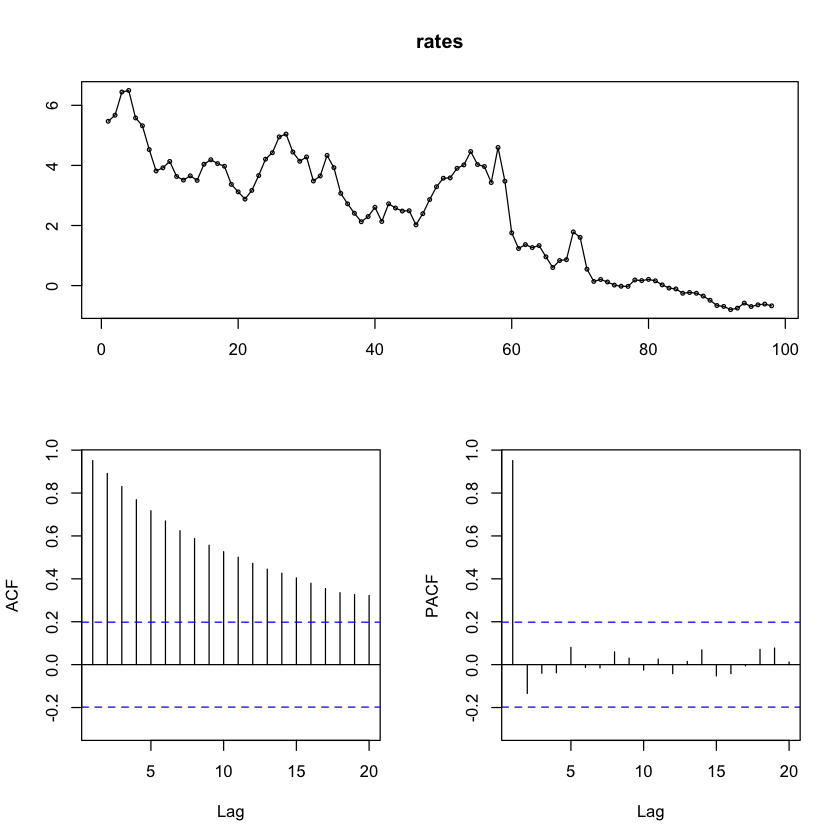

In [71]:
# Короткосрочная ставка:
dates <- as.yearqtr(df$`Germany Bund 2 Year Yield`$Date, format = "%Y-%m-%d")
rates <- zooreg(df$`Germany Bund 2 Year Yield`$PX_LAST, order.by = dates)
tsdisplay(rates)

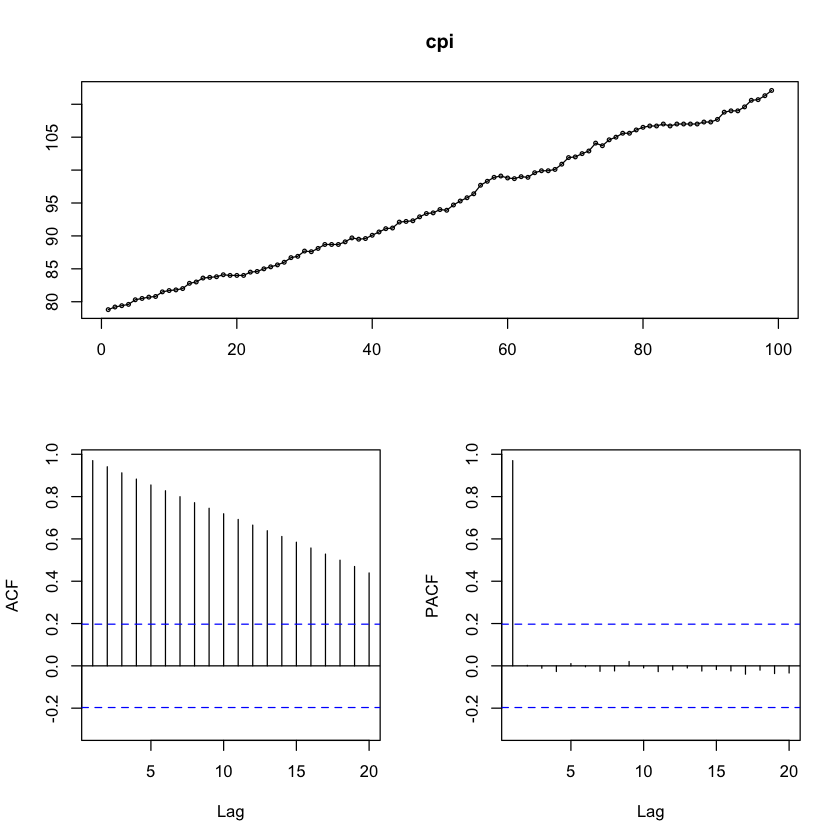

In [72]:
# Индекс CPI:
dates <- as.yearqtr(df$CPI_quater$Quarter, format = "%Y-%m-%d")
cpi <- zooreg(df$CPI_quater$CPI, order.by = dates)
tsdisplay(cpi)

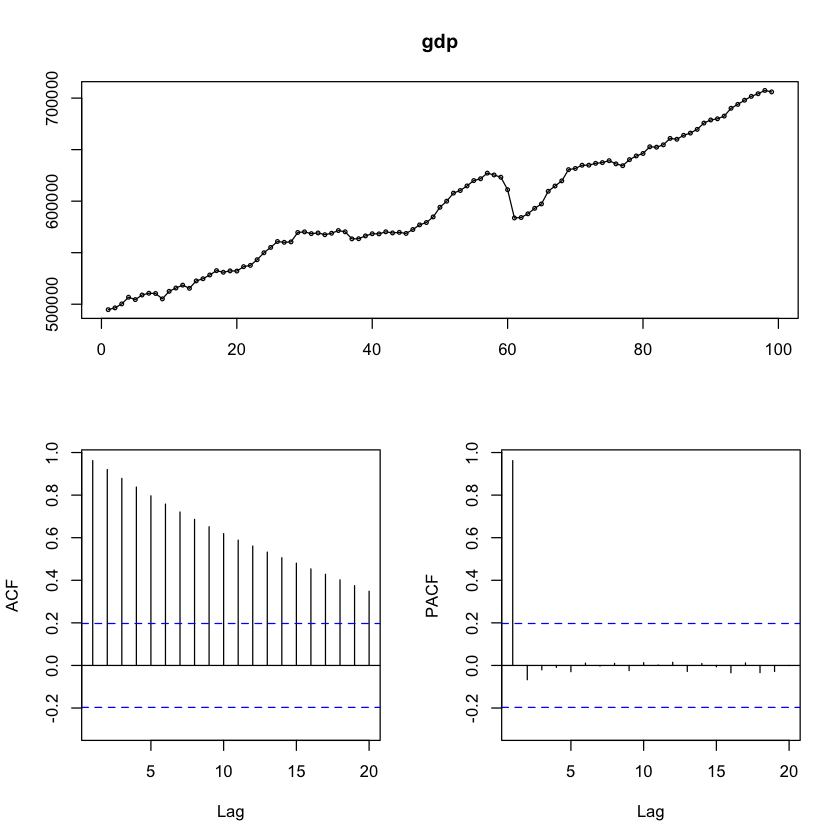

In [73]:
# Реальный ВВП в постоянных ценах 2005 г. в национальной валюте
dates <- as.yearqtr(df$GDP_2005localCurrency$Date, format = "%Y-%m-%d")
gdp <- zooreg(df$GDP_2005localCurrency$PX_LAST, order.by = dates)
tsdisplay(gdp)

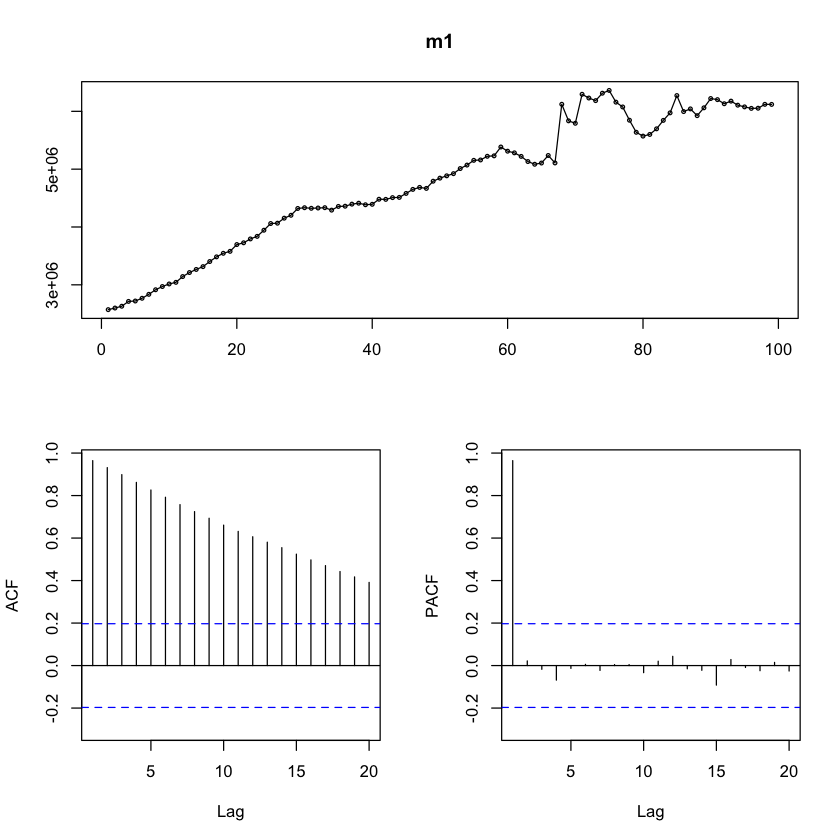

In [74]:
# Денежный агрегатор M1 в национальной валюте:
dates <- as.yearqtr(df$M1_quater$Date, format = "%Y-%m")
m1 <- zooreg(df$M1_quater$M1, order.by = dates)
tsdisplay(m1)

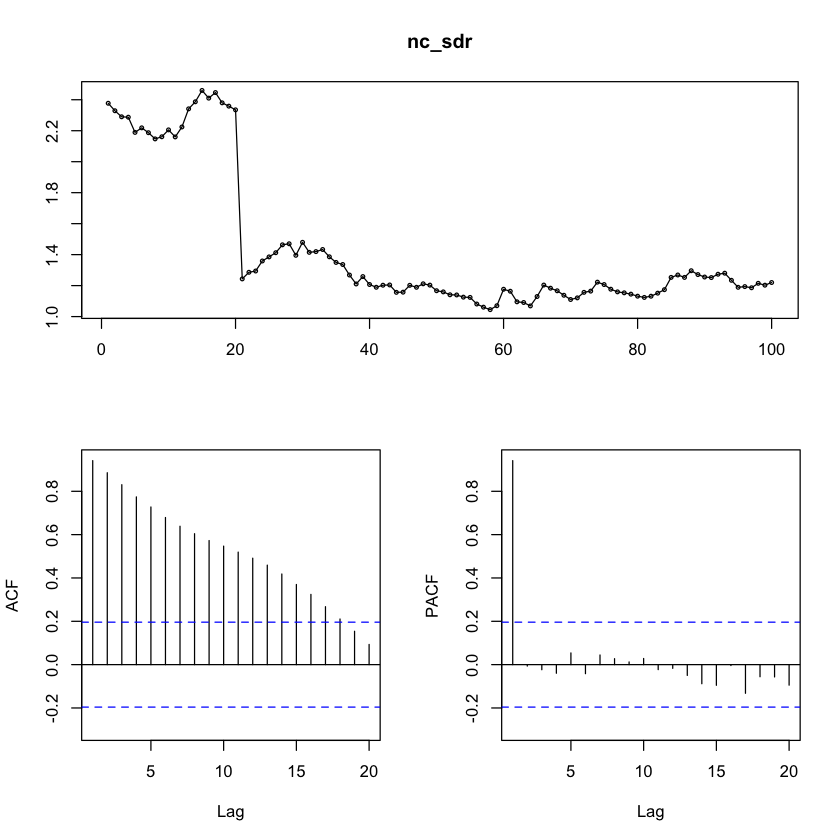

In [75]:
# Национальная валюта / SDR
dates1 <- as.yearqtr(df$Cur_SDR$Date, format = "%Y-%m-%d")
nc_sdr <- zooreg(df$Cur_SDR$NC_SDR, order.by = dates1)
tsdisplay(nc_sdr)

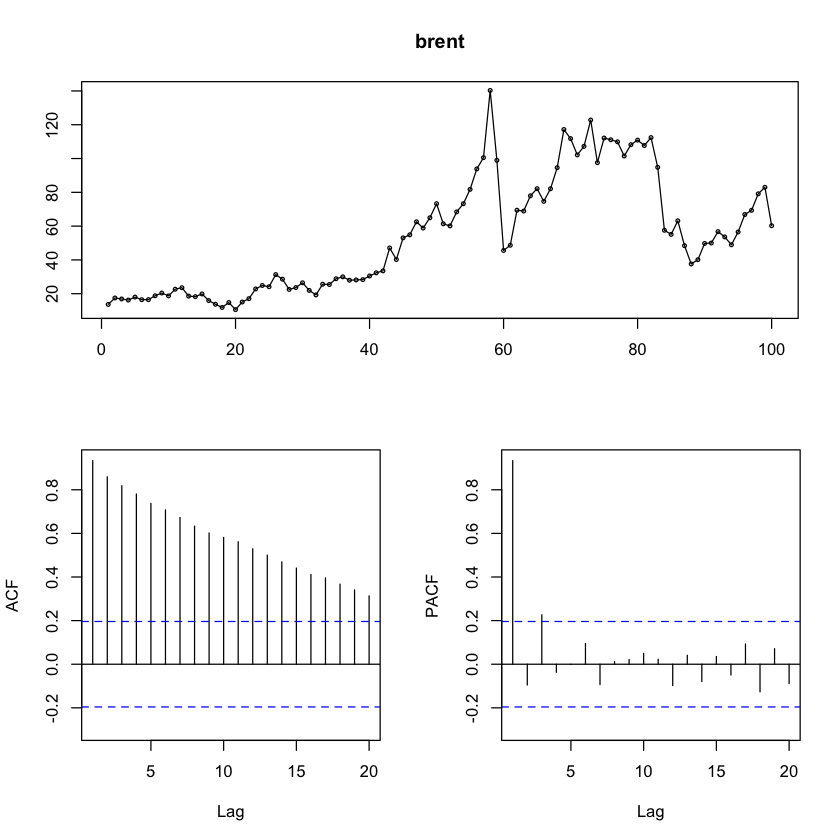

In [76]:
# Brent
dates <- as.yearqtr(df$BRENT_QUATER$`<DATE>`, format = "%d.%m.%Y")
brent <- zooreg(df$BRENT_QUATER$`<CLOSE>`, order.by = dates)
tsdisplay(brent)

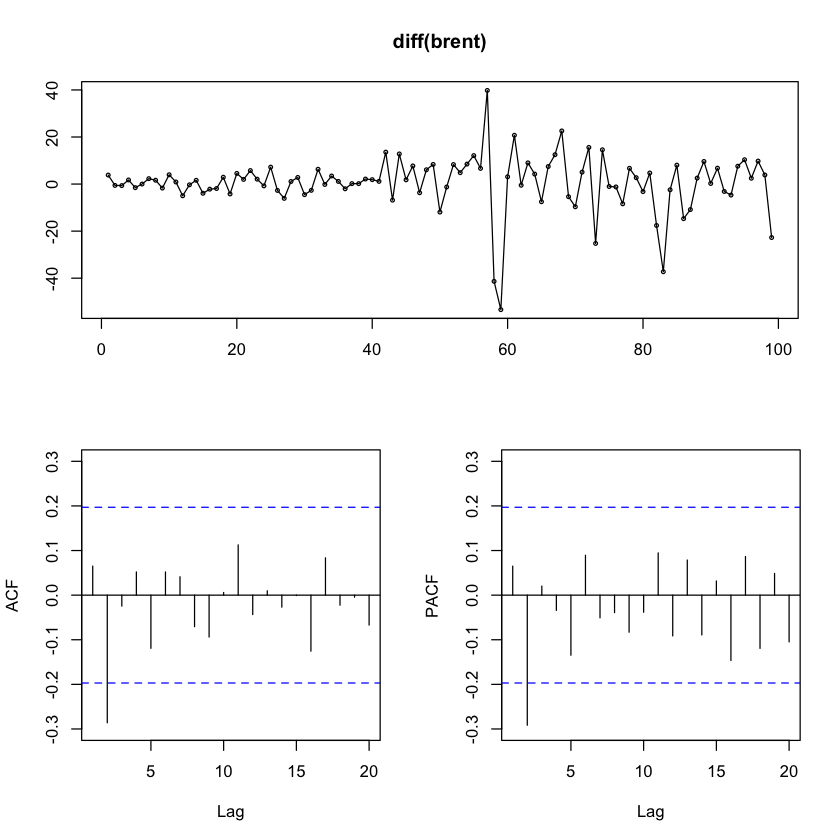

In [77]:
tsdisplay(diff(brent))

Получились разные количества доступных наблюдений для каждой переменной, моэтому возьмем наименьшее количество наблюдений, чтобы были включены все переменные, сократим временной интервал до 2-го квартала 2018-го года:

In [78]:
cpi <- cpi[1:length(cpi)-1]
gdp <- gdp[1:length(gdp)-1]
m1 <- m1[1:length(m1)-1]
nc_sdr <- nc_sdr[2:length(nc_sdr)-2]
brent <- brent[2:length(brent)-2]

Исходя из методологии исследователей из статьи, прологарифмируем все переменные за исключение доходности(rates), отношения NC/SDR(nc_sdr), цены нефти марки brent(brent):

In [79]:
ln_cpi <- log(cpi)
ln_gdp <- log(gdp)
ln_m1 <- log(m1)

Как видно из вышепредставленных графиков врменных рядов, ACF и PACF - все ряды нестационарны. Проведем тесты ADf, PP-теста, для того, чтобы определить порядок интегрируемости, а также проверим остатки вспомогательной модели на наличие автокорреляции с помощью теста Льюинга-Бокса. Напомним, что в тесте ADF \[H_0\] = наличие единичного корня. Полученная тестовая статистика сравнивается с критическими значениями MacKinnon. Если t-статистика < критического значения MacKinnon, то гипотеза о наличии единичного корня отвергается(ряд стационарен). В PP-тесте  \[H_0\] = наличие стационарности, а в тесте Льюинга-Бокса \[H_0\] = ряд представляет собой белый шум, т.е. нет автокорреляции в остатках. Будет проводить тест Результаты тестов, представлены ниже:

In [80]:
# Ряд доходностей 2-х летних гос. облигаций
test <- (ur.df(rates, type = "trend"))
Box.test(test@res, type= "Ljung-Box")
summary(test)
pp.test(as.numeric(rates))


	Box-Ljung test

data:  test@res
X-squared = 0.00018315, df = 1, p-value = 0.9892



############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression trend 


Call:
lm(formula = z.diff ~ z.lag.1 + 1 + tt + z.diff.lag)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.10704 -0.16327 -0.02884  0.19471  1.60329 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)   
(Intercept)  0.826668   0.294504   2.807  0.00610 **
z.lag.1     -0.162430   0.051156  -3.175  0.00204 **
tt          -0.010023   0.003574  -2.805  0.00615 **
z.diff.lag   0.253927   0.100587   2.524  0.01330 * 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.4151 on 92 degrees of freedom
Multiple R-squared:  0.126,	Adjusted R-squared:  0.09747 
F-statistic:  4.42 on 3 and 92 DF,  p-value: 0.00598


Value of test-statistic is: -3.1752 3.9213 5.0525 

Critical values for test statistics: 
      1pct  5pct 10pct
tau3 -4.04 -3.45 -3.15
phi2  6.5

Phillips-Perron Unit Root Test 
alternative: stationary 
 
Type 1: no drift no trend 
 lag Z_rho p.value
   3 -2.67   0.346
----- 
 Type 2: with drift no trend 
 lag Z_rho p.value
   3 -2.79   0.675
----- 
 Type 3: with drift and trend 
 lag Z_rho p.value
   3 -15.7   0.182
--------------- 
Note: p-value = 0.01 means p.value <= 0.01 


Как видно из результатов теста ряд rates получился нестационарным, т.к. Value of test-statistic (-3.1752) > Critical values tau3 (-3.45) на 5% значимости, что означает, что гипотеза о наличии единичного корня не отвергается. Остальные значения тестовой статистики(phi2, phi3) говорят о целесообразности влючения в модель дрифта и тренда. 

PP-тест, также показал, что присутствует автокорреляция с p-значением большим 0,05 во всех трех спецификациях теста.

В остатках из вспомогательной модели к тесту ADF отвергается гипотеза о наличие автокорреляции(p-value = 0.9892), поэтому результаты ADF теста можно считать достоверными. 

Проведем те же самые тесты для первой разности ряда rates:

In [81]:
# 1-й разность доходностей 2-х летних гос. облигаций
test <- (ur.df(diff(rates), type = "trend"))
Box.test(test@res, type= "Ljung-Box")
summary(test)
pp.test(as.numeric(diff(rates)))


	Box-Ljung test

data:  test@res
X-squared = 6.8514e-05, df = 1, p-value = 0.9934



############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression trend 


Call:
lm(formula = z.diff ~ z.lag.1 + 1 + tt + z.diff.lag)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.35540 -0.18768  0.02253  0.18797  1.32294 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.1102663  0.0899335  -1.226    0.223    
z.lag.1     -0.9674543  0.1304176  -7.418 6.03e-11 ***
tt           0.0007714  0.0015930   0.484    0.629    
z.diff.lag   0.1546488  0.1013220   1.526    0.130    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.4257 on 91 degrees of freedom
Multiple R-squared:  0.4451,	Adjusted R-squared:  0.4268 
F-statistic: 24.33 on 3 and 91 DF,  p-value: 1.195e-11


Value of test-statistic is: -7.4181 18.4127 27.5961 

Critical values for test statistics: 
      1pct  5pct 10pct
tau3 -4.04 -3.45 -

Phillips-Perron Unit Root Test 
alternative: stationary 
 
Type 1: no drift no trend 
 lag Z_rho p.value
   3 -73.3    0.01
----- 
 Type 2: with drift no trend 
 lag Z_rho p.value
   3 -73.6    0.01
----- 
 Type 3: with drift and trend 
 lag Z_rho p.value
   3 -73.5    0.01
--------------- 
Note: p-value = 0.01 means p.value <= 0.01 


Из результатов обоих тестов видно, что первая разность ряда rates стационарна (из ADF: test-statistic -7.4181 < -3.45 и из PP-теста p-value < 0.05). Таким образом, \[rates - I(1)\]. 

Аналогичным образом проведем тесты для других рядов:

In [82]:
# Ряд ln_CPI 
test <- (ur.df(ln_cpi, type = "trend"))
Box.test(test@res, type= "Ljung-Box")
summary(test)
pp.test(as.numeric(ln_cpi))
# ln_CPI 1-я разность
test <- (ur.df(diff(ln_cpi), type = "trend"))
Box.test(test@res, type= "Ljung-Box")
summary(test)
pp.test(as.numeric(diff(ln_cpi)))
# Получился I(1)


	Box-Ljung test

data:  test@res
X-squared = 0.0024613, df = 1, p-value = 0.9604



############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression trend 


Call:
lm(formula = z.diff ~ z.lag.1 + 1 + tt + z.diff.lag)

Residuals:
       Min         1Q     Median         3Q        Max 
-0.0058808 -0.0026170 -0.0005155  0.0021950  0.0103519 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)  
(Intercept)  0.3726432  0.1992325   1.870   0.0646 .
z.lag.1     -0.0845037  0.0456836  -1.850   0.0676 .
tt           0.0003036  0.0001676   1.812   0.0733 .
z.diff.lag  -0.0384492  0.1051898  -0.366   0.7156  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.003509 on 92 degrees of freedom
Multiple R-squared:  0.0442,	Adjusted R-squared:  0.01304 
F-statistic: 1.418 on 3 and 92 DF,  p-value: 0.2425


Value of test-statistic is: -1.8498 20.1745 1.7993 

Critical values for test statistics: 
      1pct  5pct 10pct
tau3 -4.0

Phillips-Perron Unit Root Test 
alternative: stationary 
 
Type 1: no drift no trend 
 lag  Z_rho p.value
   3 0.0759   0.706
----- 
 Type 2: with drift no trend 
 lag  Z_rho p.value
   3 -0.199   0.944
----- 
 Type 3: with drift and trend 
 lag Z_rho p.value
   3  -9.3   0.484
--------------- 
Note: p-value = 0.01 means p.value <= 0.01 



	Box-Ljung test

data:  test@res
X-squared = 0.0013264, df = 1, p-value = 0.9709



############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression trend 


Call:
lm(formula = z.diff ~ z.lag.1 + 1 + tt + z.diff.lag)

Residuals:
       Min         1Q     Median         3Q        Max 
-0.0067863 -0.0029291 -0.0004679  0.0021863  0.0099982 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  3.936e-03  9.577e-04   4.110 8.65e-05 ***
z.lag.1     -1.027e+00  1.542e-01  -6.658 2.05e-09 ***
tt          -5.893e-06  1.345e-05  -0.438    0.662    
z.diff.lag  -5.276e-02  1.050e-01  -0.503    0.616    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.003586 on 91 degrees of freedom
Multiple R-squared:  0.5426,	Adjusted R-squared:  0.5275 
F-statistic: 35.98 on 3 and 91 DF,  p-value: 2.003e-15


Value of test-statistic is: -6.6581 14.777 22.1655 

Critical values for test statistics: 
      1pct  5pct 10p

Phillips-Perron Unit Root Test 
alternative: stationary 
 
Type 1: no drift no trend 
 lag Z_rho p.value
   3   -52    0.01
----- 
 Type 2: with drift no trend 
 lag Z_rho p.value
   3  -108    0.01
----- 
 Type 3: with drift and trend 
 lag Z_rho p.value
   3  -109    0.01
--------------- 
Note: p-value = 0.01 means p.value <= 0.01 


In [83]:
# Ряд ln_GDP 
test <- (ur.df(ln_gdp, type = "trend"))
Box.test(test@res, type= "Ljung-Box")
summary(test)
pp.test(as.numeric(ln_gdp))
# ln_GDP 1-я разность
test <- (ur.df(diff(ln_gdp), type = "trend"))
Box.test(test@res, type= "Ljung-Box")
summary(test)
pp.test(as.numeric(diff(ln_gdp)))
# Получился I(1)


	Box-Ljung test

data:  test@res
X-squared = 0.354, df = 1, p-value = 0.5519



############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression trend 


Call:
lm(formula = z.diff ~ z.lag.1 + 1 + tt + z.diff.lag)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.040629 -0.003422  0.000397  0.003611  0.016327 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.8030983  0.5712079   3.157 0.002158 ** 
z.lag.1     -0.1372241  0.0435296  -3.152 0.002186 ** 
tt           0.0004558  0.0001463   3.116 0.002444 ** 
z.diff.lag   0.3807364  0.0968067   3.933 0.000163 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.007391 on 92 degrees of freedom
Multiple R-squared:  0.1844,	Adjusted R-squared:  0.1578 
F-statistic: 6.931 on 3 and 92 DF,  p-value: 0.0002941


Value of test-statistic is: -3.1524 6.4589 4.9741 

Critical values for test statistics: 
      1pct  5pct 10pct
tau3 -4.

Phillips-Perron Unit Root Test 
alternative: stationary 
 
Type 1: no drift no trend 
 lag  Z_rho p.value
   3 0.0269   0.695
----- 
 Type 2: with drift no trend 
 lag  Z_rho p.value
   3 -0.444   0.927
----- 
 Type 3: with drift and trend 
 lag Z_rho p.value
   3 -16.1   0.163
--------------- 
Note: p-value = 0.01 means p.value <= 0.01 



	Box-Ljung test

data:  test@res
X-squared = 0.00509, df = 1, p-value = 0.9431



############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression trend 


Call:
lm(formula = z.diff ~ z.lag.1 + 1 + tt + z.diff.lag)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.042376 -0.003538  0.000537  0.004173  0.015388 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  2.128e-03  1.695e-03   1.255    0.213    
z.lag.1     -6.605e-01  1.228e-01  -5.377 5.81e-07 ***
tt           5.505e-06  2.919e-05   0.189    0.851    
z.diff.lag  -4.275e-02  1.046e-01  -0.409    0.684    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.007802 on 91 degrees of freedom
Multiple R-squared:  0.347,	Adjusted R-squared:  0.3255 
F-statistic: 16.12 on 3 and 91 DF,  p-value: 1.749e-08


Value of test-statistic is: -5.3771 9.6424 14.4627 

Critical values for test statistics: 
      1pct  5pct 10pct
tau3 -4.

Phillips-Perron Unit Root Test 
alternative: stationary 
 
Type 1: no drift no trend 
 lag Z_rho p.value
   3 -55.8    0.01
----- 
 Type 2: with drift no trend 
 lag Z_rho p.value
   3 -67.8    0.01
----- 
 Type 3: with drift and trend 
 lag Z_rho p.value
   3 -67.8    0.01
--------------- 
Note: p-value = 0.01 means p.value <= 0.01 


In [84]:
# Ряд ln_M1 
test <- (ur.df(ln_m1, type = "trend"))
Box.test(test@res, type= "Ljung-Box")
summary(test)
pp.test(as.numeric(ln_m1))
# ln_M1 1-я разность
test <- (ur.df(diff(ln_m1), type = "trend"))
Box.test(test@res, type= "Ljung-Box")
summary(test)
pp.test(as.numeric(diff(ln_m1)))
# Получился I(1)


	Box-Ljung test

data:  test@res
X-squared = 0.0026347, df = 1, p-value = 0.9591



############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression trend 


Call:
lm(formula = z.diff ~ z.lag.1 + 1 + tt + z.diff.lag)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.048239 -0.012017 -0.001865  0.008188  0.166768 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)  
(Intercept)  0.9345697  0.5175021   1.806   0.0742 .
z.lag.1     -0.0611242  0.0346961  -1.762   0.0814 .
tt           0.0002863  0.0003151   0.909   0.3660  
z.diff.lag  -0.1919808  0.1012878  -1.895   0.0612 .
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.0249 on 92 degrees of freedom
Multiple R-squared:  0.1206,	Adjusted R-squared:  0.09193 
F-statistic: 4.206 on 3 and 92 DF,  p-value: 0.007779


Value of test-statistic is: -1.7617 8.2525 4.9174 

Critical values for test statistics: 
      1pct  5pct 10pct
tau3 -4.04 -3.45 -3.

Phillips-Perron Unit Root Test 
alternative: stationary 
 
Type 1: no drift no trend 
 lag  Z_rho p.value
   3 0.0558   0.701
----- 
 Type 2: with drift no trend 
 lag Z_rho p.value
   3 -2.45   0.714
----- 
 Type 3: with drift and trend 
 lag Z_rho p.value
   3 -5.74   0.746
--------------- 
Note: p-value = 0.01 means p.value <= 0.01 



	Box-Ljung test

data:  test@res
X-squared = 0.0033286, df = 1, p-value = 0.954



############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression trend 


Call:
lm(formula = z.diff ~ z.lag.1 + 1 + tt + z.diff.lag)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.049132 -0.012707 -0.001505  0.008799  0.169295 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.0234687  0.0061830   3.796 0.000265 ***
z.lag.1     -1.2411504  0.1637449  -7.580 2.81e-11 ***
tt          -0.0002536  0.0001009  -2.514 0.013709 *  
z.diff.lag   0.0172592  0.1048282   0.165 0.869590    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.02543 on 91 degrees of freedom
Multiple R-squared:  0.6098,	Adjusted R-squared:  0.5969 
F-statistic:  47.4 on 3 and 91 DF,  p-value: < 2.2e-16


Value of test-statistic is: -7.5798 19.1513 28.7266 

Critical values for test statistics: 
      1pct  5pct 10pct
tau3 -4

Phillips-Perron Unit Root Test 
alternative: stationary 
 
Type 1: no drift no trend 
 lag Z_rho p.value
   3  -117    0.01
----- 
 Type 2: with drift no trend 
 lag Z_rho p.value
   3  -123    0.01
----- 
 Type 3: with drift and trend 
 lag Z_rho p.value
   3  -124    0.01
--------------- 
Note: p-value = 0.01 means p.value <= 0.01 


In [85]:
# Ряд ln_NC_SDR 
test <- (ur.df(nc_sdr, type = "trend"))
Box.test(test@res, type= "Ljung-Box")
summary(test)
pp.test(as.numeric(nc_sdr))
# ln_NC_SDR 1-я разность
test <- (ur.df(diff(nc_sdr), type = "trend"))
Box.test(test@res, type= "Ljung-Box")
summary(test)
pp.test(as.numeric(diff(nc_sdr)))
# Получился I(1)


	Box-Ljung test

data:  test@res
X-squared = 3.6615e-05, df = 1, p-value = 0.9952



############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression trend 


Call:
lm(formula = z.diff ~ z.lag.1 + 1 + tt + z.diff.lag)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.02214 -0.02217  0.00667  0.03359  0.17294 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)  
(Intercept)  0.1260256  0.0869961   1.449   0.1508  
z.lag.1     -0.0794700  0.0411617  -1.931   0.0566 .
tt          -0.0004807  0.0006550  -0.734   0.4648  
z.diff.lag   0.0094196  0.1041196   0.090   0.9281  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1175 on 92 degrees of freedom
Multiple R-squared:  0.05056,	Adjusted R-squared:  0.0196 
F-statistic: 1.633 on 3 and 92 DF,  p-value: 0.1871


Value of test-statistic is: -1.9307 1.9437 2.4343 

Critical values for test statistics: 
      1pct  5pct 10pct
tau3 -4.04 -3.45 -3.15
phi2  6.5

Phillips-Perron Unit Root Test 
alternative: stationary 
 
Type 1: no drift no trend 
 lag Z_rho p.value
   3 -1.21    0.47
----- 
 Type 2: with drift no trend 
 lag Z_rho p.value
   3 -5.48    0.43
----- 
 Type 3: with drift and trend 
 lag Z_rho p.value
   3 -7.97   0.575
--------------- 
Note: p-value = 0.01 means p.value <= 0.01 



	Box-Ljung test

data:  test@res
X-squared = 1.6773e-06, df = 1, p-value = 0.999



############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression trend 


Call:
lm(formula = z.diff ~ z.lag.1 + 1 + tt + z.diff.lag)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.06670 -0.01771  0.00211  0.03443  0.14807 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.0343123  0.0258265  -1.329    0.187    
z.lag.1     -1.0317187  0.1504082  -6.859 8.14e-10 ***
tt           0.0004615  0.0004557   1.013    0.314    
z.diff.lag   0.0022700  0.1048428   0.022    0.983    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1205 on 91 degrees of freedom
Multiple R-squared:  0.5146,	Adjusted R-squared:  0.4986 
F-statistic: 32.16 on 3 and 91 DF,  p-value: 2.893e-14


Value of test-statistic is: -6.8595 15.686 23.5261 

Critical values for test statistics: 
      1pct  5pct 10pct
tau3 -4.04 -3.45 -3

Phillips-Perron Unit Root Test 
alternative: stationary 
 
Type 1: no drift no trend 
 lag Z_rho p.value
   3 -97.8    0.01
----- 
 Type 2: with drift no trend 
 lag Z_rho p.value
   3 -98.1    0.01
----- 
 Type 3: with drift and trend 
 lag Z_rho p.value
   3 -98.4    0.01
--------------- 
Note: p-value = 0.01 means p.value <= 0.01 


In [86]:
# Ряд ln_brent 
test <- (ur.df(brent, type = "trend"))
Box.test(test@res, type= "Ljung-Box")
summary(test)
pp.test(as.numeric(brent))
# ln_NC_SDR 1-я разность
test <- (ur.df(diff(brent), type = "trend"))
Box.test(test@res, type= "Ljung-Box")
summary(test)
pp.test(as.numeric(diff(brent)))
# Получился I(1)


	Box-Ljung test

data:  test@res
X-squared = 0.10853, df = 1, p-value = 0.7418



############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression trend 


Call:
lm(formula = z.diff ~ z.lag.1 + 1 + tt + z.diff.lag)

Residuals:
    Min      1Q  Median      3Q     Max 
-42.994  -3.858  -0.272   4.819  43.758 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)   
(Intercept)  2.20784    2.42162   0.912  0.36430   
z.lag.1     -0.13522    0.05074  -2.665  0.00909 **
tt           0.11343    0.06137   1.848  0.06778 . 
z.diff.lag   0.14260    0.10404   1.371  0.17383   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 11.34 on 92 degrees of freedom
Multiple R-squared:  0.07665,	Adjusted R-squared:  0.04654 
F-statistic: 2.546 on 3 and 92 DF,  p-value: 0.06082


Value of test-statistic is: -2.6651 2.4649 3.563 

Critical values for test statistics: 
      1pct  5pct 10pct
tau3 -4.04 -3.45 -3.15
phi2  6.50  4.88  4.16
p

Phillips-Perron Unit Root Test 
alternative: stationary 
 
Type 1: no drift no trend 
 lag  Z_rho p.value
   3 -0.591   0.557
----- 
 Type 2: with drift no trend 
 lag Z_rho p.value
   3 -5.39   0.436
----- 
 Type 3: with drift and trend 
 lag Z_rho p.value
   3 -11.2   0.397
--------------- 
Note: p-value = 0.01 means p.value <= 0.01 



	Box-Ljung test

data:  test@res
X-squared = 0.003981, df = 1, p-value = 0.9497



############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression trend 


Call:
lm(formula = z.diff ~ z.lag.1 + 1 + tt + z.diff.lag)

Residuals:
    Min      1Q  Median      3Q     Max 
-43.720  -3.566  -0.195   5.006  42.028 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   1.3713     2.3846   0.575  0.56668    
z.lag.1      -1.2001     0.1373  -8.740  1.1e-13 ***
tt           -0.0123     0.0424  -0.290  0.77231    
z.diff.lag    0.2919     0.1006   2.901  0.00467 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 11.32 on 91 degrees of freedom
Multiple R-squared:  0.5079,	Adjusted R-squared:  0.4917 
F-statistic: 31.31 on 3 and 91 DF,  p-value: 5.361e-14


Value of test-statistic is: -8.74 25.4728 38.2052 

Critical values for test statistics: 
      1pct  5pct 10pct
tau3 -4.04 -3.45 -3.15
phi2  6.50  4.88  

Phillips-Perron Unit Root Test 
alternative: stationary 
 
Type 1: no drift no trend 
 lag Z_rho p.value
   3 -76.5    0.01
----- 
 Type 2: with drift no trend 
 lag Z_rho p.value
   3 -76.5    0.01
----- 
 Type 3: with drift and trend 
 lag Z_rho p.value
   3 -76.5    0.01
--------------- 
Note: p-value = 0.01 means p.value <= 0.01 


Таким образом все остальные логарифмы рядов получились I(1).

In [87]:
d_rates <- diff(rates)
d_ln_cpi <- diff(ln_cpi)
d_ln_gdp <- diff(ln_gdp)
d_ln_m1 <- diff(ln_m1)
d_nc_sdr <- diff(nc_sdr)
d_brent <- diff(brent)

## 2. Построение модели ARIMA и прогноз по ней на 1 шаг вперед.

Построим модель ARIMA для ln_gdp.

Для построения данной модели воспользуемся методологией Бокса-Дженкинса:

1. Порядок интегрируемости для ряда ln_gdp, как было уже ранее установлено, равен 1. 

2. Для определения p, q в ARIMA (p,1,q) построим ACF и PACF для первой разности нашего ряда:

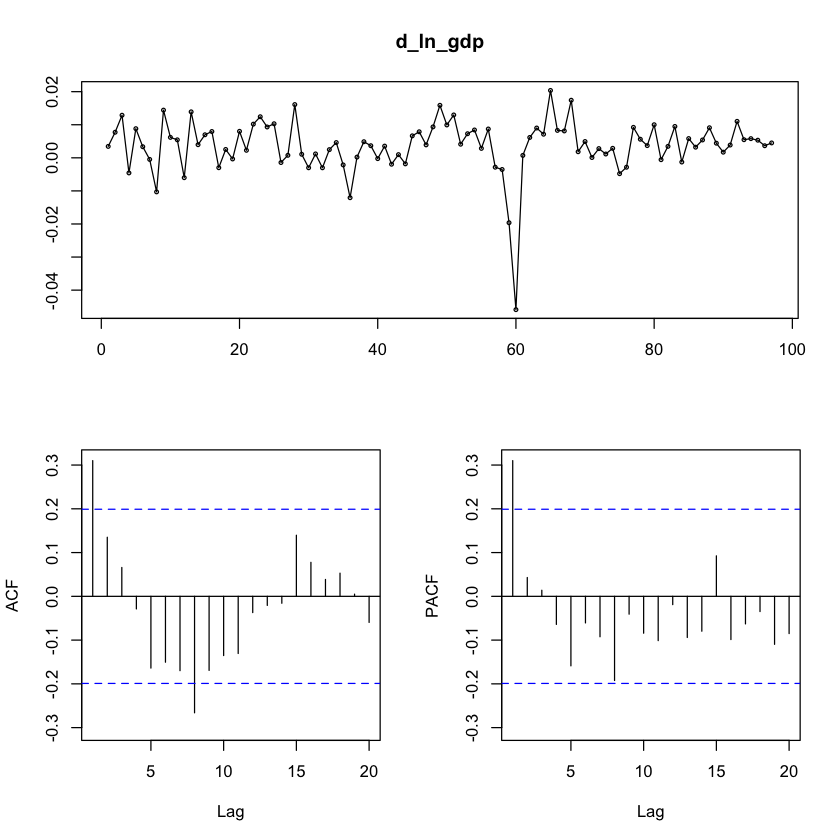

In [88]:
tsdisplay(d_ln_gdp)

В соответствии с графиком PACF  возьмем лаги для AR = (1)
В соответствии с графиком ACF возьмем лаги для MA = (1)

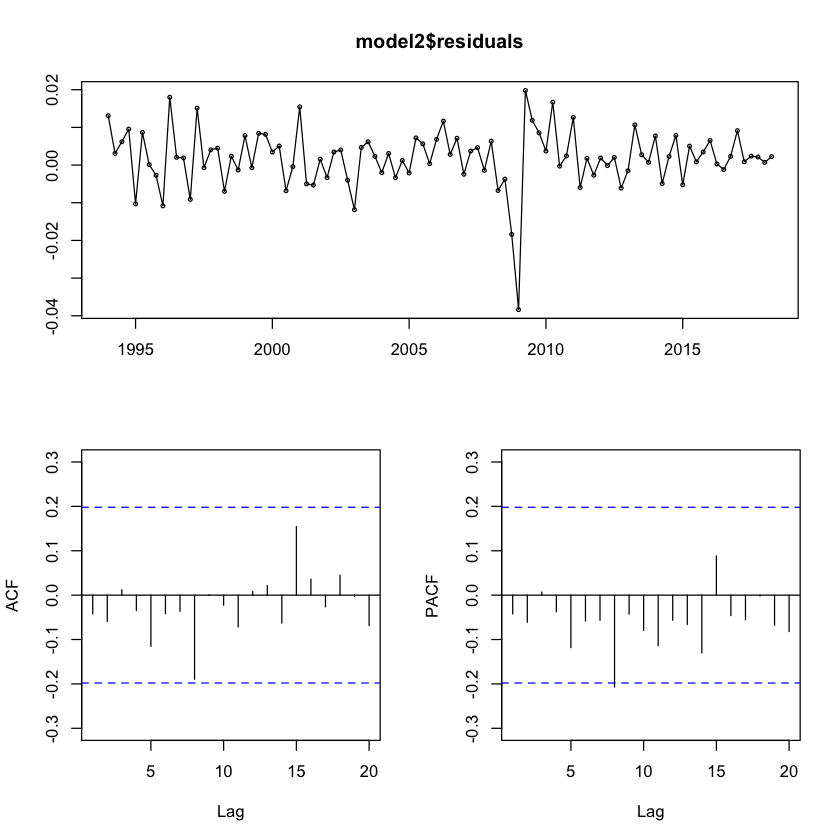

In [89]:
model2 <- arima(ln_gdp, order = c(1,1,1), include.mean = T)
tsdisplay(model2$residuals)

In [90]:
summary(model2)
coeftest(model2)


Call:
arima(x = ln_gdp, order = c(1, 1, 1), include.mean = T)

Coefficients:
         ar1      ma1
      0.6784  -0.3143
s.e.  0.1569   0.2020

sigma^2 estimated as 6.164e-05:  log likelihood = 332.41,  aic = -658.83

Training set error measures:
                      ME        RMSE         MAE      MPE       MAPE      MASE
Training set 0.001872177 0.007922171 0.005668168 0.014099 0.04271741 0.8853683
                    ACF1
Training set -0.04238953



z test of coefficients:

    Estimate Std. Error z value  Pr(>|z|)    
ar1  0.67841    0.15692  4.3232 1.538e-05 ***
ma1 -0.31434    0.20205 -1.5558    0.1198    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


С помощью функции auto.arima определим модель с лучшими информационными критериями:

In [91]:
model3 <- auto.arima(d_ln_gdp, stepwise = FALSE, parallel = T, test = c("kpss", "adf", "pp"),
ic = c("aicc", "aic", "bic"), stationary = T, approximation = F, seasonal = F)

Series: d_ln_gdp 
ARIMA(1,0,0) with non-zero mean 

Coefficients:
         ar1    mean
      0.3069  0.0037
s.e.  0.0959  0.0011

sigma^2 estimated as 5.862e-05:  log likelihood=335.93
AIC=-665.85   AICc=-665.6   BIC=-658.13

Training set error measures:
                       ME        RMSE         MAE      MPE     MAPE      MASE
Training set 3.226271e-07 0.007577179 0.005103156 74.33587 203.1668 0.6697823
                    ACF1
Training set -0.01000973



z test of coefficients:

           Estimate Std. Error z value  Pr(>|z|)    
ar1       0.3069318  0.0959129  3.2001 0.0013738 ** 
intercept 0.0036905  0.0011097  3.3258 0.0008817 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


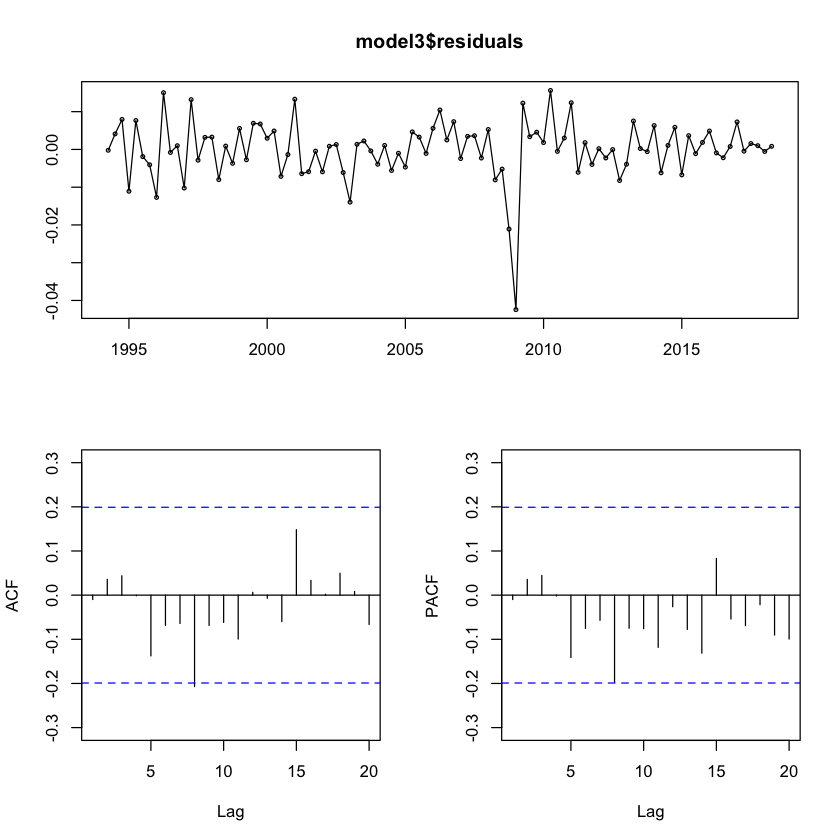

In [92]:
summary(model3)
coeftest(model3)
tsdisplay(model3$residuals)

Таким образом получилась модель ARIMA(1,1,0):
\[y_t = 0.0037+0.3069y_{t-1}+\varepsilon_t\]

Проверим с помощью теста Льюинга-Бокса на автокорреляцию в остатках:

In [93]:
Box.test(model3$residuals, type ="Ljung-Box", lag = 10, fitdf = 1)


	Box-Ljung test

data:  model3$residuals
X-squared = 8.8084, df = 9, p-value = 0.4551


На 5% уровне значимости отвергается гипотеза о наличии автокорреляции в остках модели.

Проведем тест на нормальность остатков с помощью теста Shapiro-Wilk:

In [94]:
shapiro.test(model3$residuals)


	Shapiro-Wilk normality test

data:  model3$residuals
W = 0.87466, p-value = 1.536e-07


К сожалению, тест показывает, что на 5% уровне значимости не отвергается гипотеза о наличии автокорреляции в остатках модели. Это можно объяснить небольшой выборкой.

Проверим на обратимость нашу модель ARIMA(1,1,0):

Уравнение нашего временного ряда исходя из итоговой модели можно представить в виде:

\[y_t = 0.0037+0.3069y_{t-1}+\varepsilon_t\]

Процесс AR всегда обратим => вся модель ARIMA(1,1,0) также обратима  и  стационарна => Таким образом, получается, что наш процесс ARIMA(0,1,1) обратим и стационарен и можно делать прогнозы по данной модели.

Построим прогноз на 1 день вперед c доверительными интервалами:

In [95]:
future <- forecast::forecast(model3, h = 1)
print(future)


        Point Forecast        Lo 80      Hi 80       Lo 95      Hi 95
2018 Q3    0.003940717 -0.005871513 0.01375295 -0.01106579 0.01894723


## 3. Модель VAR.

Создадим матрицу переменных, т.е. предположим, что все переменные в модели VAR эндогенные и выберем порядок лага для модели VAR:

In [96]:
varmat <- as.matrix(cbind(d_rates, d_ln_cpi, d_ln_gdp, d_ln_m1, d_nc_sdr, d_brent))
VARselect(varmat, lag.max = 4, type= "trend")

,1,2,3,4
AIC(n),-2.948922e+01,-2.941928e+01,-2.906721e+01,-2.891189e+01
HQ(n),-2.902741e+01,-2.856162e+01,-2.781371e+01,-2.726255e+01
SC(n),-2.834547e+01,-2.729516e+01,-2.596274e+01,-2.482705e+01
FPE(n),1.562198e-13,1.691108e-13,2.463009e-13,3.013104e-13


Таким образом, на основе проведенных тестов на основе информационных критериев, лучшим образом подходит модель с 1-м лагом. 

Модель VAR(1):

In [97]:
varfit <- VAR(varmat, type = "trend", lag.max = 1)
summary(varfit)


VAR Estimation Results:
Endogenous variables: d_rates, d_ln_cpi, d_ln_gdp, d_ln_m1, d_nc_sdr, d_brent 
Deterministic variables: trend 
Sample size: 96 
Log Likelihood: 639.529 
Roots of the characteristic polynomial:
0.4072 0.2429 0.1826 0.1826 0.06978 0.01633
Call:
VAR(y = varmat, type = "trend", lag.max = 1)


Estimation results for equation d_rates: 
d_rates = d_rates.l1 + d_ln_cpi.l1 + d_ln_gdp.l1 + d_ln_m1.l1 + d_nc_sdr.l1 + d_brent.l1 + trend 

              Estimate Std. Error t value Pr(>|t|)
d_rates.l1   1.490e-01  1.252e-01   1.190    0.237
d_ln_cpi.l1 -1.366e+01  1.259e+01  -1.084    0.281
d_ln_gdp.l1  3.519e+00  5.905e+00   0.596    0.553
d_ln_m1.l1   2.464e+00  1.762e+00   1.398    0.166
d_nc_sdr.l1 -1.762e-01  3.863e-01  -0.456    0.649
d_brent.l1   5.164e-03  4.798e-03   1.076    0.285
trend       -5.573e-04  1.073e-03  -0.520    0.605


Residual standard error: 0.435 on 89 degrees of freedom
Multiple R-Squared: 0.09237,	Adjusted R-squared: 0.02099 
F-statistic: 1.294 o

Проверим получившуюся модель VAR(1) на автокорреляцию c помощью обратных корней:

In [98]:
vars::roots(varfit)

[1] 0.40720098 0.24288983 0.18262686 0.18262686 0.06978198 0.01632764

Как видно из вышеприведенных значений обратные корни для остатов модели VAR(1) стационарны, т.к. получившиеся значения не превосходят по модулю 1. 

Исходя из результатов теста Фишера значимыми получились 2 уравнения для 1-й разности логарифма CPI(d_ln_cpi)(P-value = 2.575e-10 ) и для 1-й разности логарифма GDP(d_ln_gdp)(P-value = 2.745e-08). Для теста Фишера нулевая гипотеза - незначимость модели вцелом. 

Проверим остатки каждого из уравнения модели VAR(1) на наличие автокорреляции с помощью теста Льюинга-Бокса:

In [99]:
Box.test(varfit$varresult$d_rates$residuals, type= "Ljung-Box")
Box.test(varfit$varresult$d_ln_cpi$residuals, type= "Ljung-Box")
Box.test(varfit$varresult$d_ln_gdp$residuals, type= "Ljung-Box")
Box.test(varfit$varresult$d_ln_m1$residuals, type= "Ljung-Box")
Box.test(varfit$varresult$d_nc_sdr$residuals, type= "Ljung-Box")
Box.test(varfit$varresult$d_brent$residuals, type= "Ljung-Box")


	Box-Ljung test

data:  varfit$varresult$d_rates$residuals
X-squared = 0.12976, df = 1, p-value = 0.7187



	Box-Ljung test

data:  varfit$varresult$d_ln_cpi$residuals
X-squared = 1.6389, df = 1, p-value = 0.2005



	Box-Ljung test

data:  varfit$varresult$d_ln_gdp$residuals
X-squared = 0.21487, df = 1, p-value = 0.643



	Box-Ljung test

data:  varfit$varresult$d_ln_m1$residuals
X-squared = 0.89527, df = 1, p-value = 0.3441



	Box-Ljung test

data:  varfit$varresult$d_nc_sdr$residuals
X-squared = 0.016403, df = 1, p-value = 0.8981



	Box-Ljung test

data:  varfit$varresult$d_brent$residuals
X-squared = 0.054194, df = 1, p-value = 0.8159


Таким образом в остатках 6-ти уравнений модели VAR(1) не отвергается нулева гипотеза на 5% уровне значимости об отсутствии автокорреляции. 

Проведем также Тест Харке — Бера на нормальность остатков, где H0 - гипотеза о нормальности ошибок распределений:

In [100]:
normality.test(varfit)

$JB

	JB-Test (multivariate)

data:  Residuals of VAR object varfit
Chi-squared = 19429, df = 12, p-value < 2.2e-16


$Skewness

	Skewness only (multivariate)

data:  Residuals of VAR object varfit
Chi-squared = 1042, df = 6, p-value < 2.2e-16


$Kurtosis

	Kurtosis only (multivariate)

data:  Residuals of VAR object varfit
Chi-squared = 18387, df = 6, p-value < 2.2e-16


$jb.mul
$jb.mul$JB

	JB-Test (multivariate)

data:  Residuals of VAR object varfit
Chi-squared = 19429, df = 12, p-value < 2.2e-16


$jb.mul$Skewness

	Skewness only (multivariate)

data:  Residuals of VAR object varfit
Chi-squared = 1042, df = 6, p-value < 2.2e-16


$jb.mul$Kurtosis

	Kurtosis only (multivariate)

data:  Residuals of VAR object varfit
Chi-squared = 18387, df = 6, p-value < 2.2e-16




Отвергается на 5% уровне значимости гипотеза о нормальности остатков в модели VAR(2).

## 4. Тест на причинность по Грейнджеру

Проведем тест на причинность по Грейнджеру для того, чтобы лучше специфировать модель. \[H_0:\]коэффициент при лагах объясняющей переменной равен 0, т.е. нет взаимосвязи между изменениями двух временных рядов. Результаты теста приведены ниже:

In [101]:
# Для ставки d_rates:
grangertest(d_rates~d_ln_cpi, order = 1, data = as.data.frame(varmat))
grangertest(d_rates~d_ln_cpi, order = 1, data = as.data.frame(varmat))
grangertest(d_rates~d_ln_gdp, order = 1, data = as.data.frame(varmat))
grangertest(d_rates~d_ln_m1, order = 1, data = as.data.frame(varmat))
grangertest(d_rates~d_brent, order = 1, data = as.data.frame(varmat))

Res.Df,Df,F,Pr(>F)
93,NA,NA,NA
94,-1,0.001919283,0.9651501


Res.Df,Df,F,Pr(>F)
93,NA,NA,NA
94,-1,0.001919283,0.9651501


Res.Df,Df,F,Pr(>F)
93,NA,NA,NA
94,-1,1.40793,0.2384227


Res.Df,Df,F,Pr(>F)
93,NA,NA,NA
94,-1,2.755329,0.1002993


Res.Df,Df,F,Pr(>F)
93,NA,NA,NA
94,-1,0.948632,0.3325943


In [102]:
# Для d_ln_cpi:
grangertest(d_ln_cpi~d_rates, order = 1, data = as.data.frame(varmat))
grangertest(d_ln_cpi~d_ln_gdp, order = 1, data = as.data.frame(varmat))
grangertest(d_ln_cpi~d_ln_m1, order = 1, data = as.data.frame(varmat))
grangertest(d_ln_cpi~d_nc_sdr, order = 1, data = as.data.frame(varmat))
grangertest(d_ln_cpi~d_brent, order = 1, data = as.data.frame(varmat))

Res.Df,Df,F,Pr(>F)
93,NA,NA,NA
94,-1,0.01804385,0.893434


Res.Df,Df,F,Pr(>F)
93,NA,NA,NA
94,-1,2.962016,0.08856681


Res.Df,Df,F,Pr(>F)
93,NA,NA,NA
94,-1,2.203175,0.1411083


Res.Df,Df,F,Pr(>F)
93,NA,NA,NA
94,-1,0.4890525,0.4860957


Res.Df,Df,F,Pr(>F)
93,NA,NA,NA
94,-1,3.972215,0.04918752


In [103]:
# Для ставки d_ln_gdp:
grangertest(d_ln_gdp~d_rates, order = 1, data = as.data.frame(varmat))
grangertest(d_ln_gdp~d_ln_cpi, order = 1, data = as.data.frame(varmat))
grangertest(d_ln_gdp~d_ln_m1, order = 1, data = as.data.frame(varmat))
grangertest(d_ln_gdp~d_nc_sdr, order = 1, data = as.data.frame(varmat))
grangertest(d_ln_gdp~d_brent, order = 1, data = as.data.frame(varmat))

Res.Df,Df,F,Pr(>F)
93,NA,NA,NA
94,-1,15.04637,0.0001956367


Res.Df,Df,F,Pr(>F)
93,NA,NA,NA
94,-1,3.331635,0.07116916


Res.Df,Df,F,Pr(>F)
93,NA,NA,NA
94,-1,1.102861,0.2963604


Res.Df,Df,F,Pr(>F)
93,NA,NA,NA
94,-1,0.0009286869,0.975754


Res.Df,Df,F,Pr(>F)
93,NA,NA,NA
94,-1,14.18172,0.0002907276


In [104]:
# Для ставки d_ln_m1:
grangertest(d_ln_m1~d_rates, order = 1, data = as.data.frame(varmat))
grangertest(d_ln_m1~d_ln_cpi, order = 1, data = as.data.frame(varmat))
grangertest(d_ln_m1~d_ln_gdp, order = 1, data = as.data.frame(varmat))
grangertest(d_ln_m1~d_nc_sdr, order = 1, data = as.data.frame(varmat))
grangertest(d_ln_m1~d_brent, order = 1, data = as.data.frame(varmat))

Res.Df,Df,F,Pr(>F)
93,NA,NA,NA
94,-1,0.9025728,0.3445552


Res.Df,Df,F,Pr(>F)
93,NA,NA,NA
94,-1,0.4674659,0.4958553


Res.Df,Df,F,Pr(>F)
93,NA,NA,NA
94,-1,1.795406,0.1835336


Res.Df,Df,F,Pr(>F)
93,NA,NA,NA
94,-1,0.1514352,0.6980572


Res.Df,Df,F,Pr(>F)
93,NA,NA,NA
94,-1,0.002817381,0.9577828


In [105]:
# Для ставки d_nc_sdr:
grangertest(d_nc_sdr~d_rates, order = 1, data = as.data.frame(varmat))
grangertest(d_nc_sdr~d_ln_cpi, order = 1, data = as.data.frame(varmat))
grangertest(d_nc_sdr~d_ln_gdp, order = 1, data = as.data.frame(varmat))
grangertest(d_nc_sdr~d_ln_m1, order = 1, data = as.data.frame(varmat))
grangertest(d_nc_sdr~d_brent, order = 1, data = as.data.frame(varmat))

Res.Df,Df,F,Pr(>F)
93,NA,NA,NA
94,-1,0.05505926,0.8149985


Res.Df,Df,F,Pr(>F)
93,NA,NA,NA
94,-1,0.6032228,0.439322


Res.Df,Df,F,Pr(>F)
93,NA,NA,NA
94,-1,0.7484261,0.3892011


Res.Df,Df,F,Pr(>F)
93,NA,NA,NA
94,-1,0.228295,0.6339121


Res.Df,Df,F,Pr(>F)
93,NA,NA,NA
94,-1,0.003431699,0.9534118


In [106]:
# Для ставки d_brent:
grangertest(d_brent~d_rates, order = 1, data = as.data.frame(varmat))
grangertest(d_brent~d_ln_cpi, order = 1, data = as.data.frame(varmat))
grangertest(d_brent~d_ln_gdp, order = 1, data = as.data.frame(varmat))
grangertest(d_brent~d_ln_m1, order = 1, data = as.data.frame(varmat))
grangertest(d_brent~d_nc_sdr, order = 1, data = as.data.frame(varmat))

Res.Df,Df,F,Pr(>F)
93,NA,NA,NA
94,-1,0.9668114,0.3280278


Res.Df,Df,F,Pr(>F)
93,NA,NA,NA
94,-1,0.2054419,0.6514195


Res.Df,Df,F,Pr(>F)
93,NA,NA,NA
94,-1,0.07099121,0.7904889


Res.Df,Df,F,Pr(>F)
93,NA,NA,NA
94,-1,1.486586,0.2258303


Res.Df,Df,F,Pr(>F)
93,NA,NA,NA
94,-1,0.05318721,0.8181139


Вычисленные значения p-value показывают: 
лаги d_ln_gdp помогают предсказать значения d_ln_cpi на 10% уровне значимости(p-value = 0.08857)
лаги d_brent помогают объяснить измение значений d_ln_cpi на 5% уровне значимости(p-value = 0.04919)
лаги d_rates помогают объяснить значения d_ln_gdp на 5% уровне значимости(p-value = 0,0001956)
лаги d_ln_cpi помогают объяснить d_ln_gdp на 10% уровне значимости(p-value = )
лаги d_brent помогают объяснить измение значения ряда d_ln_gdp на 5% уровне значимости(p-value = 0.0002907)
Других причинно-следственных связей на адекватном уровне зачимости не было установлено.

Модель VAR для лучшей спецификации можно изменить следующим образом:
Удалим из модели d_ln_m1, d_nc_sdr
Оставим d_ln_gdp, d_ln_cpi в эндогенных факторах
Добавим d_rates, d_brent в экзогенные факторы

Определим количество лагов для того, чтобы лучше оценить модель VAR:

In [107]:
varmat2 <- as.matrix(cbind(d_rates, d_ln_cpi, d_ln_gdp, d_brent))
VARselect(varmat2, lag.max = 4, type= "trend")

,1,2,3,4
AIC(n),-1.812051e+01,-1.818413e+01,-1.805356e+01,-1.814184e+01
HQ(n),-1.790060e+01,-1.778829e+01,-1.748179e+01,-1.739414e+01
SC(n),-1.757587e+01,-1.720377e+01,-1.663749e+01,-1.629005e+01
FPE(n),1.350644e-08,1.269951e-08,1.454246e-08,1.343746e-08


В этот раз, нельзя так однозначно сказать, какой лучше взять порядок лага. Поэтому руководствуясь принципом, что AIC при малых выборках дает лучший результат, чем HQ, то возьмем лаг 2. 

In [108]:
exog <- as.matrix(cbind(d_rates, d_brent))
endog <- as.matrix(cbind(d_ln_cpi, d_ln_gdp))
varfit2 <- VAR(endog, type = "const", lag.max = 2, exogen = exog)
summary(varfit2)


VAR Estimation Results:
Endogenous variables: d_ln_cpi, d_ln_gdp 
Deterministic variables: const 
Sample size: 96 
Log Likelihood: 757.606 
Roots of the characteristic polynomial:
0.316 0.1468
Call:
VAR(y = endog, type = "const", exogen = exog, lag.max = 2)


Estimation results for equation d_ln_cpi: 
d_ln_cpi = d_ln_cpi.l1 + d_ln_gdp.l1 + const + d_rates + d_brent 

              Estimate Std. Error t value Pr(>|t|)    
d_ln_cpi.l1 -0.0872808  0.0923142  -0.945 0.346920    
d_ln_gdp.l1  0.0635845  0.0410500   1.549 0.124865    
const        0.0035911  0.0004926   7.289  1.1e-10 ***
d_rates      0.0007185  0.0008632   0.832 0.407388    
d_brent      0.0001182  0.0000320   3.692 0.000379 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


Residual standard error: 0.003169 on 91 degrees of freedom
Multiple R-Squared: 0.2285,	Adjusted R-squared: 0.1946 
F-statistic:  6.74 on 4 and 91 DF,  p-value: 8.5e-05 


Estimation results for equation d_ln_gdp: 
d_ln_gdp = d_ln_

Проверим получившуюся модель VAR(1) на автокорреляцию c помощью обратных корней:

In [109]:
vars::roots(varfit2)

[1] 0.3160404 0.1467840

Как видно из вышеприведенных значений обратные корни для остатов модели VAR(1) стационарны, т.к. получившиеся значения не превосходят по модулю 1. 

Исходя из результатов теста Фишера значимыми получились все уравнения в модели:
для 1-й разности логарифма CPI(d_ln_cpi)(P-value = 8.5e-05 )
для 1-й разности логарифма GDP(d_ln_gdp)(P-value = 0.0002806). для теста Фишера нулевая гипотеза - незначимость модели вцелом. 

Проверим остатки каждого из уравнения модели VAR(1) на наличие автокорреляции с помощью теста Льюинга-Бокса:

In [110]:
Box.test(varfit2$varresult$d_ln_cpi$residuals, type= "Ljung-Box")
Box.test(varfit2$varresult$d_ln_gdp$residuals, type= "Ljung-Box")


	Box-Ljung test

data:  varfit2$varresult$d_ln_cpi$residuals
X-squared = 0.78391, df = 1, p-value = 0.3759



	Box-Ljung test

data:  varfit2$varresult$d_ln_gdp$residuals
X-squared = 1.2819, df = 1, p-value = 0.2575


Таким образом, в остатках 6-ти уравнений модели VAR(1) не отвергается нулевая гипотеза на 5% уровне значимости об отсутствии автокорреляции. 

Проведем также Тест Харке — Бера на нормальность остатков, где H0 - гипотеза о нормальности ошибок распределений:

In [111]:
normality.test(varfit2)

$JB

	JB-Test (multivariate)

data:  Residuals of VAR object varfit2
Chi-squared = 367.23, df = 4, p-value < 2.2e-16


$Skewness

	Skewness only (multivariate)

data:  Residuals of VAR object varfit2
Chi-squared = 57.648, df = 2, p-value = 3.033e-13


$Kurtosis

	Kurtosis only (multivariate)

data:  Residuals of VAR object varfit2
Chi-squared = 309.58, df = 2, p-value < 2.2e-16


$jb.mul
$jb.mul$JB

	JB-Test (multivariate)

data:  Residuals of VAR object varfit2
Chi-squared = 367.23, df = 4, p-value < 2.2e-16


$jb.mul$Skewness

	Skewness only (multivariate)

data:  Residuals of VAR object varfit2
Chi-squared = 57.648, df = 2, p-value = 3.033e-13


$jb.mul$Kurtosis

	Kurtosis only (multivariate)

data:  Residuals of VAR object varfit2
Chi-squared = 309.58, df = 2, p-value < 2.2e-16




Таким оьразом, отвергается на 5% уровне значимости гипотеза о нормальности остатков в модели VAR(2).

Импульсивные отклики:

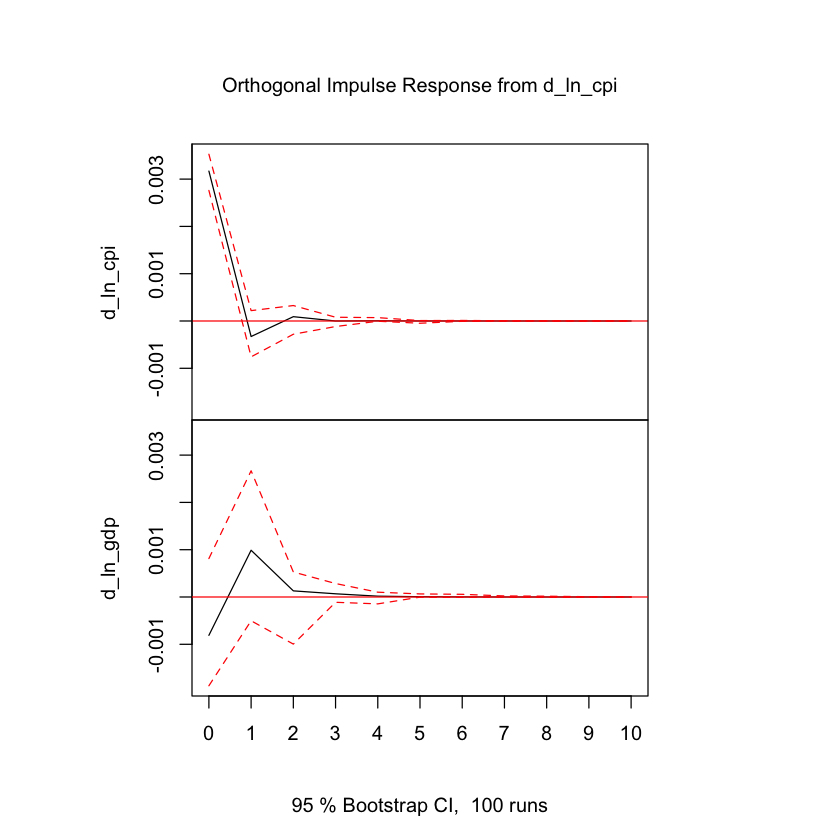

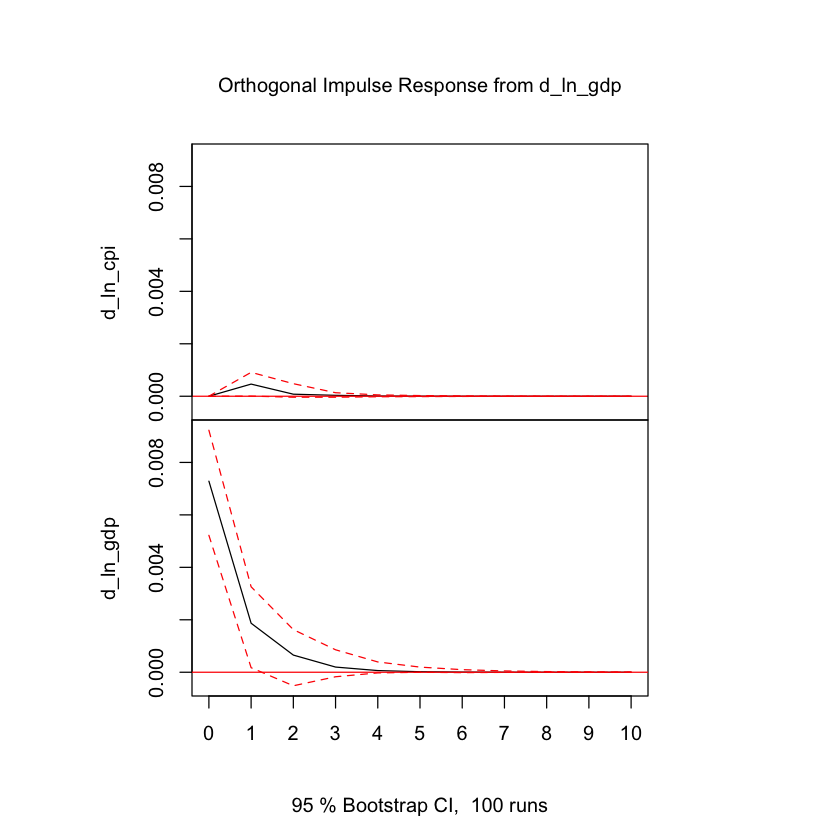

In [112]:
# Здесь может быть понадобится в консоли нажать Enter, чтобы график отобразился
impresp <- irf(varfit2)
plot(impresp)

Разложение дисперсии ошибок:

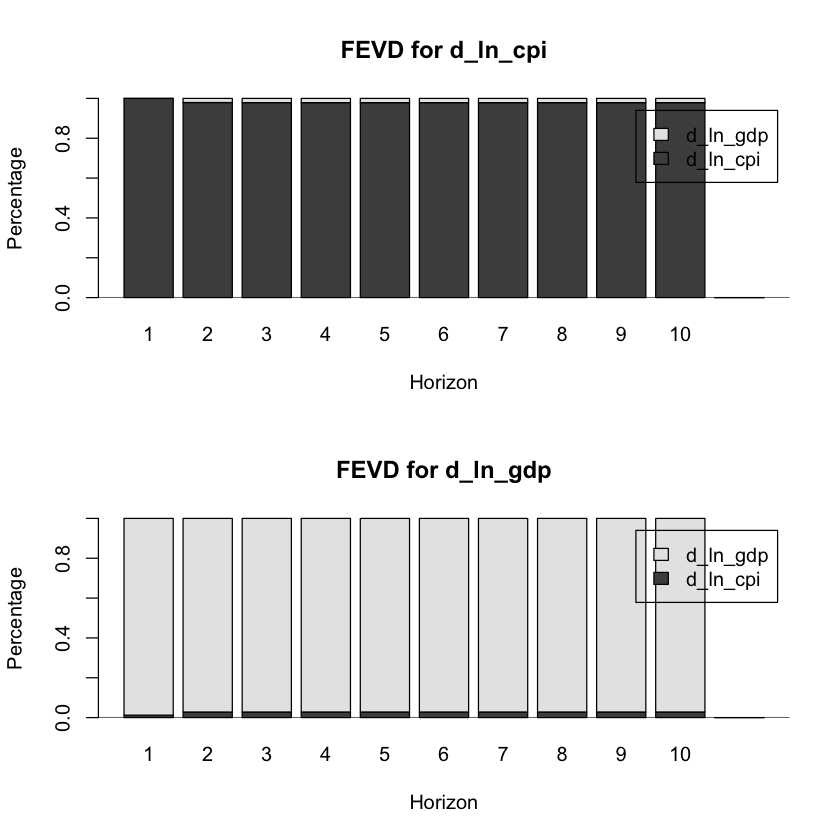

In [113]:
plot(fevd(varfit2))

Таким образом ряды d_ln_cpi и d_ln_gdp реагируют в основном на свои собственные шоки, возникающие в лагах до 10-го порядка.

# 5. Тест Ингла-Грейнджера на коинтеграцию. Построение моделей ECM.

Для начало построим парные графики первоначальных рядов, для того, чтобы визуально убедиться в наличии коинтеграции между рядами:

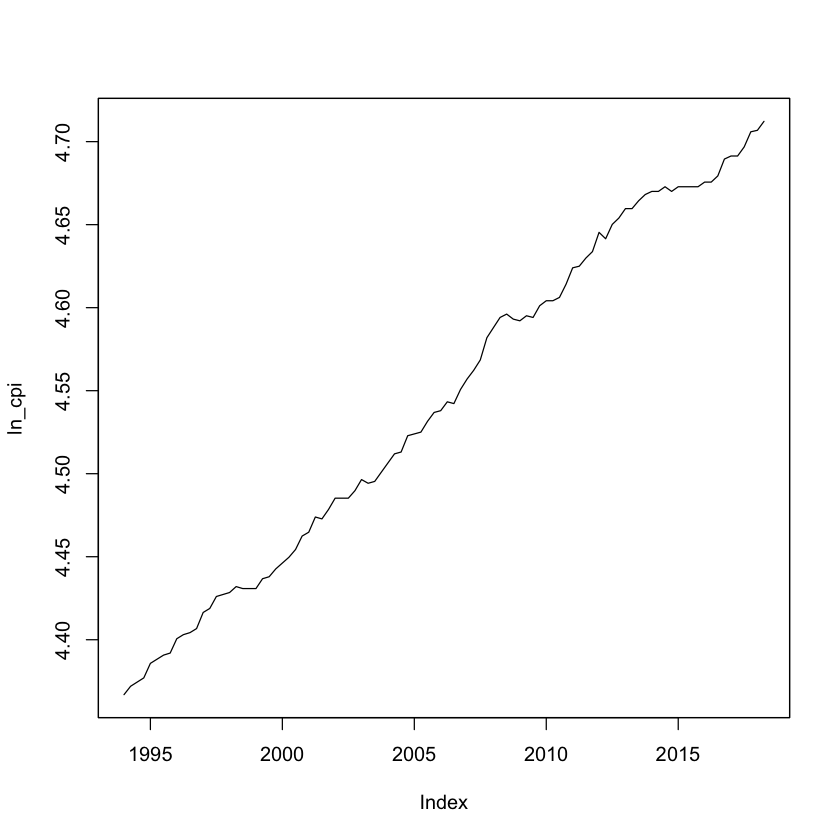

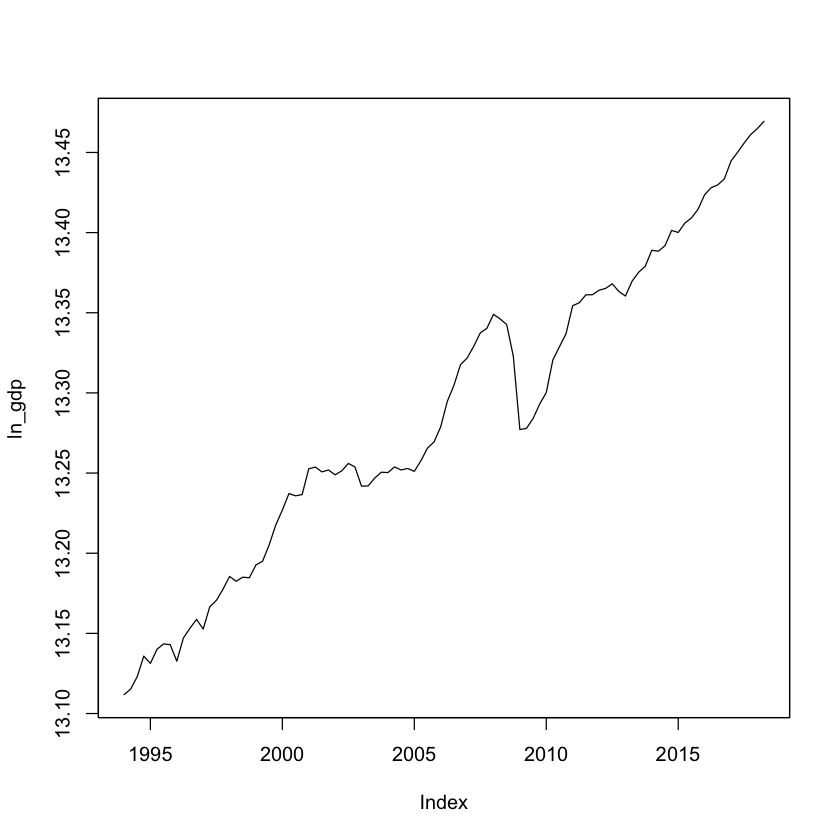

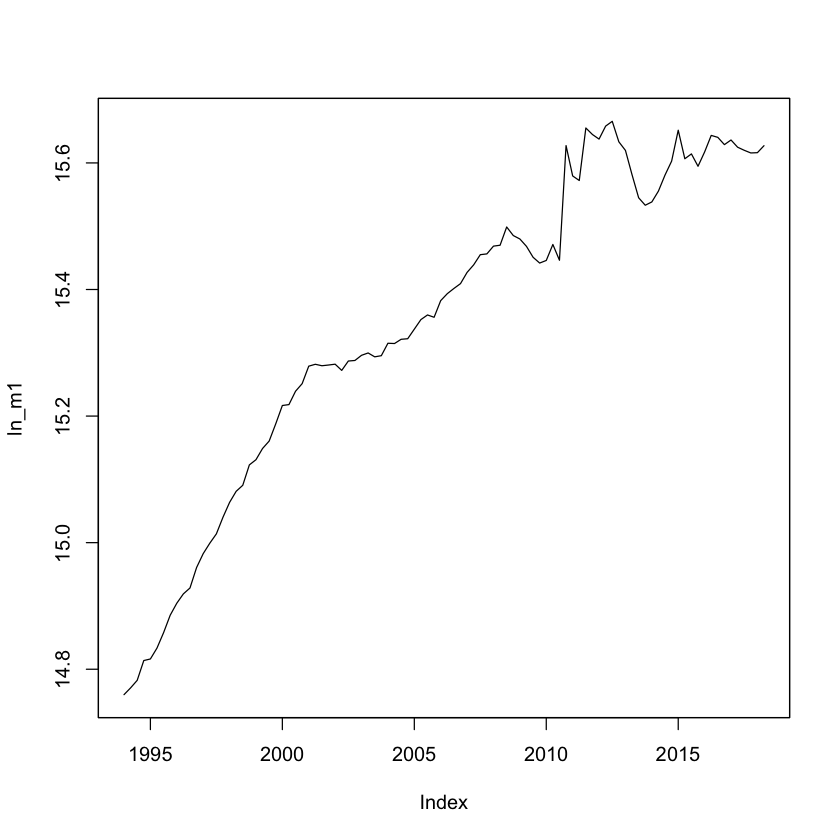

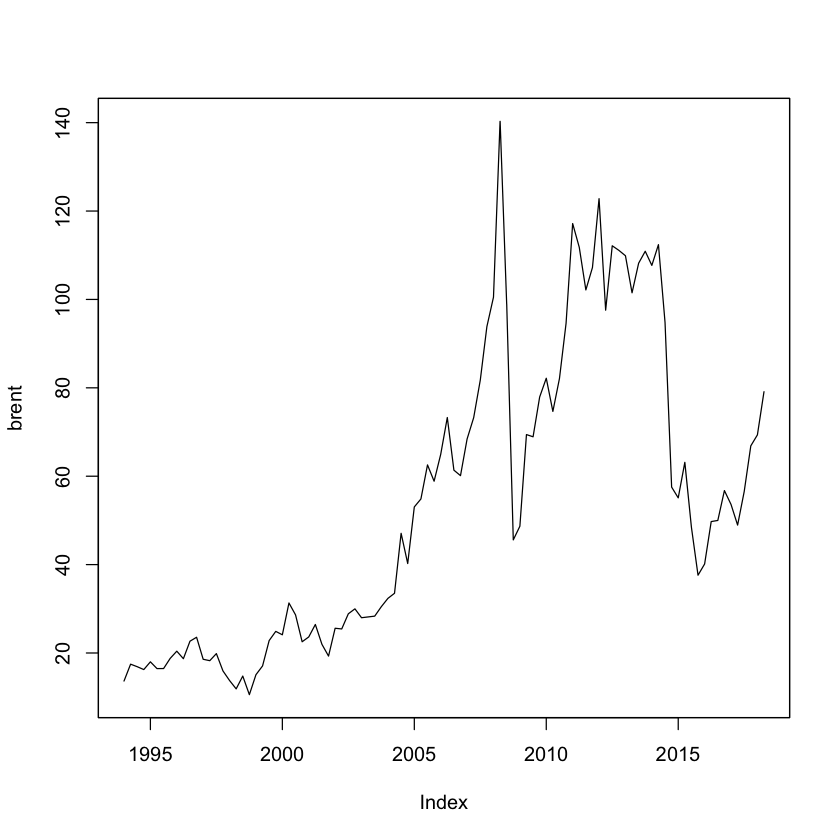

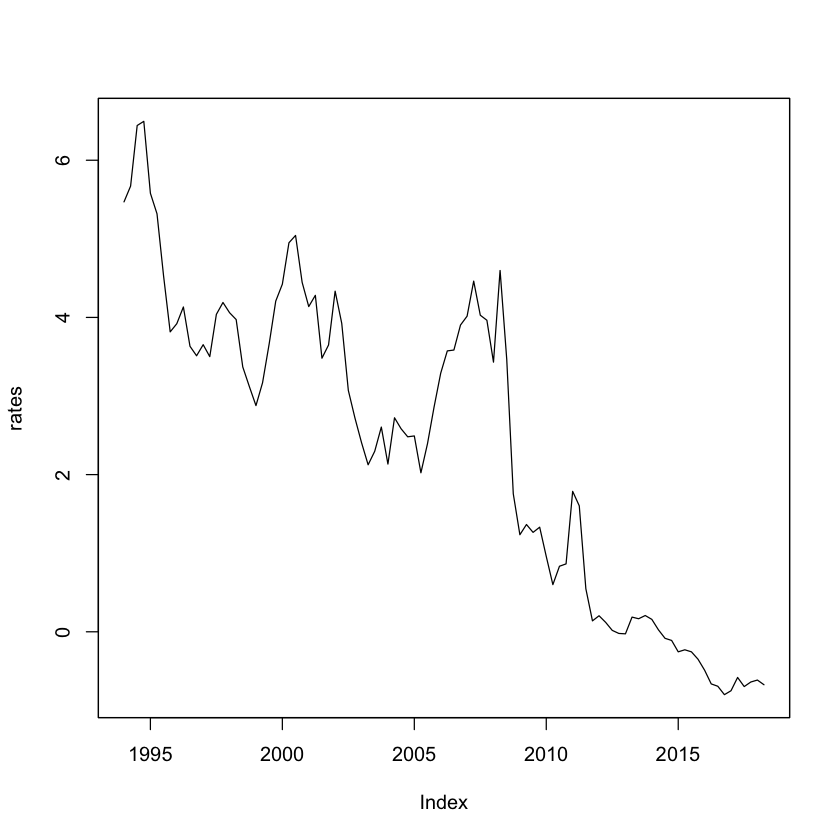

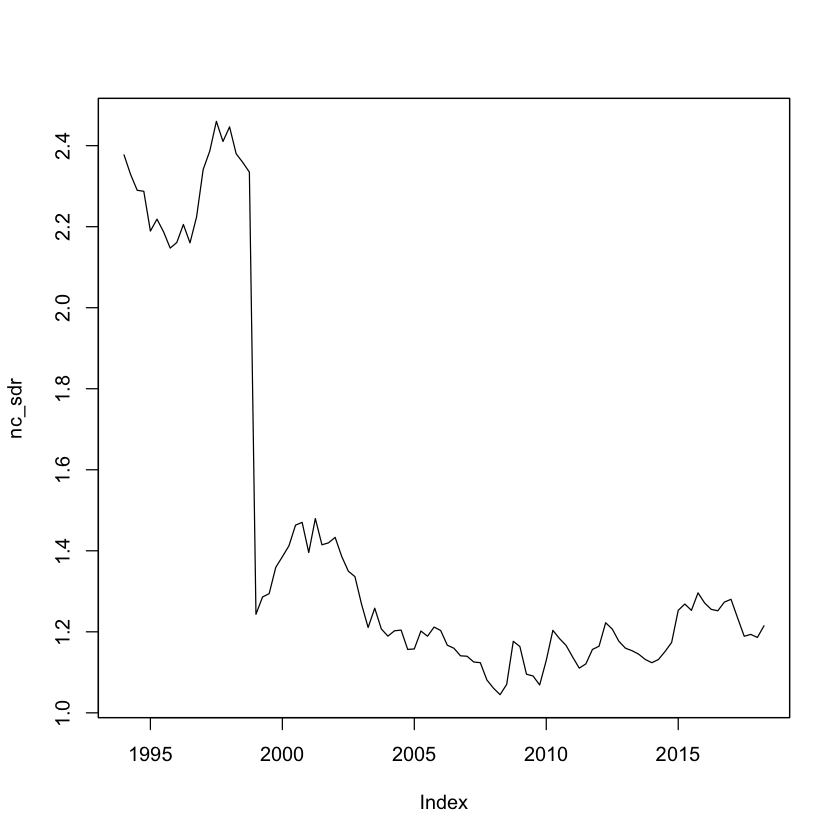

In [114]:
zoo::plot.zoo(ln_cpi)
zoo::plot.zoo(ln_gdp)
zoo::plot.zoo(ln_m1)
zoo::plot.zoo(brent)
zoo::plot.zoo(rates)
zoo::plot.zoo(nc_sdr)

Проведем двухшаговую процедуру Ингла-Грейнджера:

Шаг 1. Определение порядка интегрируемости

Из пункта 1 мы определили, что все ряды ~ I(1)

Шаг 2б. Коитеграционный вектор неизвестен.

Сначала строится вспомогательная регрессия вида:

\[y_t = \alpha + \beta x_t + \epsilon_t\]

Затем сохраняются из нее остатки, и на основе ее рассчитывается вспомогательная регрессию и тестрируется гипотеза $H_0:\rho=0$,  т.е. ряд $e_t$ принадлежит к классу DS и коинтеграции нет. В этом тесте используются критические точки МакКиннона. 

In [115]:
coint <- function(x){
  d <- as.matrix(x)
  n <- length(colnames(x))
  m <- combn(n, 2) # Число возможных комбинаций попарных 
  col_m <- dim(m)[2]
  result <- matrix(NA, nrow= col_m, ncol = 5)
  colnames(result) <- c("Response", "Input", "no trend", "linear trend", "quadratic trend")
  for (i in 1:col_m){
    Var_1 <- m[1, i]
    Var_2 <- m[2, i]
    res <- (coint.test(d[,Var_1], d[,Var_2], nlag = 4, output = F))
    result[i,1]<-colnames(x)[Var_1]
    result[i,2]<-colnames(x)[Var_2]
    result[i,3]<-toString(res[1,"p.value"])
    result[i,4]<-toString(res[2,"p.value"])
    result[i,5]<-toString(res[3,"p.value"])
  }
  return(result)
}

Создаем матрицу с нашими всеми первоначальными рядами и проводим попарный коинтеграционный тест Ингла-Грейнджера:

In [116]:

dt2 <- as.matrix(cbind(rates, ln_gdp, ln_m1, brent, ln_cpi, nc_sdr))
res1 <- coint(dt2)

Составим аналогичную таблицу повторно, т.к. при небольших выборках, тест м.б. чувствителен от того, в каком порядке стоят попарно тестируемые ряды. Таким образом, составим матрицу, где бы столбцы шли в обратном порядке. 

In [117]:
dt2 <- as.matrix(cbind(nc_sdr, ln_cpi, brent, ln_m1, ln_gdp, rates))
res2 <- coint(dt2)

Из приведенных таблиц res1 и res2 можно сказать, что вероятней всего существует с 10% уровнем значимости коинтеграция между рядами ln_gdp и rates(т.к. показано в первом случае 0.018, а во втором 0.068) и между ln_cpi и ln_gdp(в первом случае - 0.076, во втором - 0.08). Поскольку эти ряды приводятся к стационарному виду в результате взятия первой разности, то обе коинтеграции CI(1,1).

Построим модели ECM для для этих пар. 

Для начала оценим по МНК долгосрочные соотношения между этими рядами:

ln_gdp(t) = b*rates(t)
ln_cpi(t) = b*ln_gdp(t)

Возьмем остатки из этих моделей и проверим их на стационарность с помощью теста ADF:

In [118]:
mod1 <- lm(ln_gdp~rates-1)
mod2 <- lm(ln_cpi~ln_gdp-1)

summary(mod1)
summary(mod2)

test1 <- (ur.df(mod1$residuals, type = "none"))
test2 <- (ur.df(mod2$residuals, type = "none"))

summary(test1)
summary(test2)


Call:
lm(formula = ln_gdp ~ rates - 1)

Residuals:
    Min      1Q  Median      3Q     Max 
-8.2709  0.2285  4.4753 12.7392 16.0703 

Coefficients:
      Estimate Std. Error t value Pr(>|t|)    
rates   3.2959     0.2857   11.54   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 8.673 on 97 degrees of freedom
Multiple R-squared:  0.5784,	Adjusted R-squared:  0.574 
F-statistic: 133.1 on 1 and 97 DF,  p-value: < 2.2e-16



Call:
lm(formula = ln_cpi ~ ln_gdp - 1)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.117405 -0.076388 -0.003803  0.073690  0.105592 

Coefficients:
        Estimate Std. Error t value Pr(>|t|)    
ln_gdp 0.3420072  0.0005487   623.3   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.07218 on 97 degrees of freedom
Multiple R-squared:  0.9998,	Adjusted R-squared:  0.9997 
F-statistic: 3.885e+05 on 1 and 97 DF,  p-value: < 2.2e-16



############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression none 


Call:
lm(formula = z.diff ~ z.lag.1 - 1 + z.diff.lag)

Residuals:
    Min      1Q  Median      3Q     Max 
-4.1782 -0.6215  0.1849  0.6473  4.9465 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)  
z.lag.1    -0.004747   0.017394  -0.273   0.7855  
z.diff.lag  0.193728   0.102736   1.886   0.0624 .
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.435 on 94 degrees of freedom
Multiple R-squared:  0.03648,	Adjusted R-squared:  0.01598 
F-statistic:  1.78 on 2 and 94 DF,  p-value: 0.1743


Value of test-statistic is: -0.2729 

Critical values for test statistics: 
     1pct  5pct 10pct
tau1 -2.6 -1.95 -1.61



############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression none 


Call:
lm(formula = z.diff ~ z.lag.1 - 1 + z.diff.lag)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.006810 -0.001438  0.001152  0.004635  0.014377 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)
z.lag.1    -0.004107   0.007137  -0.576    0.566
z.diff.lag  0.124475   0.102158   1.218    0.226

Residual standard error: 0.004946 on 94 degrees of freedom
Multiple R-squared:  0.01919,	Adjusted R-squared:  -0.001679 
F-statistic: 0.9196 on 2 and 94 DF,  p-value: 0.4023


Value of test-statistic is: -0.5755 

Critical values for test statistics: 
     1pct  5pct 10pct
tau1 -2.6 -1.95 -1.61


Оба тестовых значения получились меньше тестовой статистики, что говорит о том, что нулевая гипотеза о наличии в остатках единичного корня отвергается. Таким образом получается, что возможна коинтеграция CI(1,1) с коинтегрирующими векторами (1, -3.2959) для пары (ln_gdp, rates) и (1, 0.1174) для пары (ln_cpi, ln_gdp)

Построим модель ECM вида:

\[ \Delta y_t = \mu +\phi\Delta x_t + \gamma(y_{t-1} - \beta x_{t-1})+\epsilon_t\]

Для модели d_rates ~ d_ln_gdp мы исключим константу из вспомогательной модели, т.к. в ряде rates не присутсвует тренд в отличие от ln_gdp. В этом можно удостовериться с помощью проведенного ранее ADF теста. Также проверим обе модели на нормальность остатков модели, что является очень важным условием при оценивании методом МНК.

In [119]:
# ECM модель для пары (ln_gdp, rates)
uhat1 <- (stats::lag(ln_gdp, k= 1) - as.numeric(mod1$coefficients)*stats::lag(rates, k= 1))
uhat2 <- (stats::lag(ln_cpi, k= 1) - as.numeric(mod1$coefficients)*stats::lag(ln_gdp, k= 1))

ecm1_1 <- lm(d_ln_gdp ~ d_rates + uhat1)
ecm1_2 <- lm(d_rates ~ d_ln_gdp + uhat1-1)

(summary(ecm1_1))
(summary(ecm1_2))

shapiro.test(as.numeric(ecm1_1$residuals)) # Тест на нормальность остатков
shapiro.test(as.numeric(ecm1_2$residuals))


Call:
lm(formula = d_ln_gdp ~ d_rates + uhat1)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.046718 -0.002926  0.000355  0.004580  0.018589 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.0041662  0.0010253   4.063 0.000100 ***
d_rates      0.0061576  0.0017967   3.427 0.000906 ***
uhat1       -0.0000157  0.0001190  -0.132 0.895309    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.007624 on 94 degrees of freedom
Multiple R-squared:  0.1131,	Adjusted R-squared:  0.09426 
F-statistic: 5.995 on 2 and 94 DF,  p-value: 0.003544



Call:
lm(formula = d_rates ~ d_ln_gdp + uhat1 - 1)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.33308 -0.24893  0.03867  0.18107  1.18600 

Coefficients:
         Estimate Std. Error t value Pr(>|t|)   
d_ln_gdp 14.99036    4.95993   3.022  0.00322 **
uhat1    -0.01244    0.00503  -2.473  0.01518 * 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.4162 on 95 degrees of freedom
Multiple R-squared:  0.1151,	Adjusted R-squared:  0.09646 
F-statistic: 6.178 on 2 and 95 DF,  p-value: 0.003004



	Shapiro-Wilk normality test

data:  as.numeric(ecm1_1$residuals)
W = 0.82225, p-value = 1.898e-09



	Shapiro-Wilk normality test

data:  as.numeric(ecm1_2$residuals)
W = 0.9544, p-value = 0.001991


Исходя из результатов из первой модели, коэффициент uhat1 незначим на 5% уровне значимости, а во второй - значим на 5% уровне значимости и отрицателен => имеет место быть только одностороняя коррекция rates относительно ln_gdp, причем скорость коррекции составляет 1,2%. К сожалению, для остатков обоих моделей отвергается нормальность остатков модели на 5% уровне значимости. 

В модель ECM константу оставляем для рядов(ln_cpi, ln_gdp), т.к. при проверке на стационарность с помощью теста ADF, был выявлен тренд в обоих рядах.

In [120]:
# ECM модель для пары (ln_cpi, ln_gdp)
ecm2_1 <- lm(d_ln_cpi ~ d_ln_gdp + uhat2)
ecm2_2 <- lm(d_ln_gdp ~ d_ln_cpi + uhat2)

(summary(ecm2_1))
(summary(ecm2_2))

shapiro.test(as.numeric(ecm2_1$residuals)) # Тест на нормальность остатков
shapiro.test(as.numeric(ecm2_2$residuals))


Call:
lm(formula = d_ln_cpi ~ d_ln_gdp + uhat2)

Residuals:
       Min         1Q     Median         3Q        Max 
-0.0073644 -0.0025236 -0.0006039  0.0022397  0.0098548 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)
(Intercept) 5.697e-03  6.677e-02   0.085    0.932
d_ln_gdp    1.454e-02  4.541e-02   0.320    0.750
uhat2       5.581e-05  1.701e-03   0.033    0.974

Residual standard error: 0.003552 on 94 degrees of freedom
Multiple R-squared:  0.00109,	Adjusted R-squared:  -0.02016 
F-statistic: 0.05129 on 2 and 94 DF,  p-value: 0.95



Call:
lm(formula = d_ln_gdp ~ d_ln_cpi + uhat2)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.048969 -0.002953  0.000091  0.004473  0.016812 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)
(Intercept) -0.120669   0.151055  -0.799    0.426
d_ln_cpi     0.074934   0.234008   0.320    0.750
uhat2       -0.003161   0.003848  -0.822    0.413

Residual standard error: 0.008063 on 94 degrees of freedom
Multiple R-squared:  0.008199,	Adjusted R-squared:  -0.0129 
F-statistic: 0.3886 on 2 and 94 DF,  p-value: 0.6791



	Shapiro-Wilk normality test

data:  as.numeric(ecm2_1$residuals)
W = 0.97917, p-value = 0.1263



	Shapiro-Wilk normality test

data:  as.numeric(ecm2_2$residuals)
W = 0.81968, p-value = 1.565e-09


Коэффициенты при uhat2 в обоих моделях оказались незначимы на 5% уровне значимости => коинтеграции нет

## 6. Модель VECM и тест Йохансена

Составим модель VECM для первоначальных нестационарных рядов. Для это создадим матрицу, объединяющую все ряды и выберем порядок лага для нашей VAR. Максимальный лаг, как и прежде - 4, т.к. данные квартальные:

In [121]:
varmat3 <- as.matrix(cbind(rates, ln_cpi, ln_gdp, ln_m1, nc_sdr, brent))
VARselect(varmat3, lag.max = 4, type= "trend")

,1,2,3,4
AIC(n),-2.999746e+01,-2.995573e+01,-2.992391e+01,-2.961480e+01
HQ(n),-2.953845e+01,-2.910329e+01,-2.867803e+01,-2.797549e+01
SC(n),-2.886110e+01,-2.784534e+01,-2.683949e+01,-2.555636e+01
FPE(n),9.396971e-14,9.886439e-14,1.044525e-13,1.487972e-13


Все информационные критерии говорят о том, что следует выбрать VAR(1). Построим ее:

In [122]:
varfit3 <- VAR(varmat3, type = "trend", lag.max = 1)
summary(varfit3)


VAR Estimation Results:
Endogenous variables: rates, ln_cpi, ln_gdp, ln_m1, nc_sdr, brent 
Deterministic variables: trend 
Sample size: 97 
Log Likelihood: 673.534 
Roots of the characteristic polynomial:
    1 0.9435 0.9435 0.8367 0.7275 0.7275
Call:
VAR(y = varmat3, type = "trend", lag.max = 1)


Estimation results for equation rates: 
rates = rates.l1 + ln_cpi.l1 + ln_gdp.l1 + ln_m1.l1 + nc_sdr.l1 + brent.l1 + trend 

           Estimate Std. Error t value Pr(>|t|)    
rates.l1   0.792466   0.066147  11.980   <2e-16 ***
ln_cpi.l1 -9.094482   6.555361  -1.387    0.169    
ln_gdp.l1  3.586063   2.334147   1.536    0.128    
ln_m1.l1  -0.383726   0.833854  -0.460    0.646    
nc_sdr.l1 -0.305167   0.214570  -1.422    0.158    
brent.l1   0.002283   0.003141   0.727    0.469    
trend      0.006003   0.014131   0.425    0.672    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


Residual standard error: 0.421 on 90 degrees of freedom
Multiple R-Squared: 0.9821,	Adjus

Обратные корни характеристического уравнения получившейся модели VAR(1):

In [123]:
vars::roots(varfit3)

[1] 1.0000784 0.9434757 0.9434757 0.8367239 0.7274650 0.7274650

В модели есть один обратных корень, превосходящий по модулю единицу, что говорит о возможной коинтеграции. 
Проведем тест Йохансена, выбрав 3-й случай, т.е. в данных есть линейный тренд, в коинтеграционном пространстве есть константа, но нет тренда, что соответсвует параметру include= "const" при построении вспомогательной модели VECM с одноименной функцией в библиотеке tsDyn. Полученная статистика \[\lambda_{trace}\] и  \[\lambda_{max}\] сравниваются с  критическими точками статистики и в случае, если тестовая статистика больше критического значения, то отвергается: \[H_0: r \leq r_0 \] 
Результаты тестов приведены ниже:

In [124]:
vecm1 <- VECM(varmat3, lag = 1, estim = "ML", include = "const")
ranktest1 <- rank.select(varmat3, lag = 4, fitMeasure = c("SSR", "LL"), returnModels = T)
ranktest2 <- rank.test(vecm1, type = c("eigen", "trace"), cval = 0.05)

summary(ranktest1)
summary(ranktest2)

ERROR: Error in VECM(varmat3, lag = 1, estim = "ML", include = "const"): не могу найти функцию "VECM"


Исходя из теста Йохансена и тестов на основе информационных критериев, лучшая модель VECM будет специфицирована при лаге = 1, ранг = 1. Построим такую модель VECM(1):

In [ ]:
vecm2 <- VECM(varmat3, lag = 1, estim = "ML", include = "const", r = 1)
summary(vecm2)

Матрица П модели VECM(1), которая показывает значения коэффициентов в модели:

In [ ]:
coefPI(vecm2)

Проведем оценку адекватности модели VECM(1).

Убедимся, что в модели отсутсвует автокоррреляция:

In [ ]:
Box.test(vecm2$residuals[,1], type= "Ljung-Box")
Box.test(vecm2$residuals[,2], type= "Ljung-Box")
Box.test(vecm2$residuals[,3], type= "Ljung-Box")
Box.test(vecm2$residuals[,4], type= "Ljung-Box")
Box.test(vecm2$residuals[,5], type= "Ljung-Box")
Box.test(vecm2$residuals[,6], type= "Ljung-Box")

Получается, что во всех уровнениях модели VECM(1) отвергается гипотеза о наличии автокорреляции в остатках на 5% уровне значимости. 

Таким образом модели полученные при оценивании VECM(1) с помощью теста Йохансена не совпадают с моделями ECM,  полученные с помощью процедуры Ингла-Грейнджера. Объясняться это может тем, что модели ECM оцениваются с помощью МНК, в отличие от VECM, где используется ММП. Для несмещенности МНК требует нормальность остатков, что трудно достигается на небольших выборках.

## 7. Выводы

В работе были рассмотрены и составлены внимательно все предполагаемые модели(ARIMA, VAR, ECM, VECM), были приведены все необходимые тесты с объяснениями для правильной спецификации и интерпретации результатов. Некоторые модели и ряды были представлены в графическом виде для удобства восприятия.

К сожалению, полученные модели не согласуются с полученными результатами статьи и не было установлено статистической взаимосвязи между шоками на рынке нефти и доходностью гос. облигаций, которые бы передавались через другие макроэкономческие показатели. Это можно объяснить двумя причинами. Во-первых, на рынке нефти в связи с развитие фьючерсов на нефть, пришло все большее количество участников со спекулятивными интересами, которые используют технический анализ для торговли "intraday". Технический анализ, в отличие от фундаментального анализа не предполагает анализ макроэкономичеких показателей на рынке нефти и поэтому взаимосвязь между изменениями ценами на нефть, ставкой и другими макроэкономическими показателями становится все менее значительной. Во-вторых, большая часть рассмотренного промежутка времени лежит после кризиса 2008 года. Таким образом, правительства ведущих экономик поменяли политику в отношении процентных ставок. 


